In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import math

In [2]:
df = yf.download('EURUSD=X', start='2020-01-01', end='2024-01-01')
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-01,1.122083,1.122838,1.115947,1.122083,1.122083,0
2020-01-02,1.121894,1.122712,1.116682,1.122083,1.122083,0
2020-01-03,1.117081,1.118068,1.112570,1.117144,1.117144,0
2020-01-06,1.116246,1.120825,1.115810,1.116196,1.116196,0
2020-01-07,1.119583,1.119946,1.113487,1.119799,1.119799,0
...,...,...,...,...,...,...
2023-12-25,1.102657,1.104240,1.099989,1.102657,1.102657,0
2023-12-26,1.102026,1.103997,1.100958,1.102026,1.102026,0
2023-12-27,1.104301,1.112248,1.102925,1.104301,1.104301,0


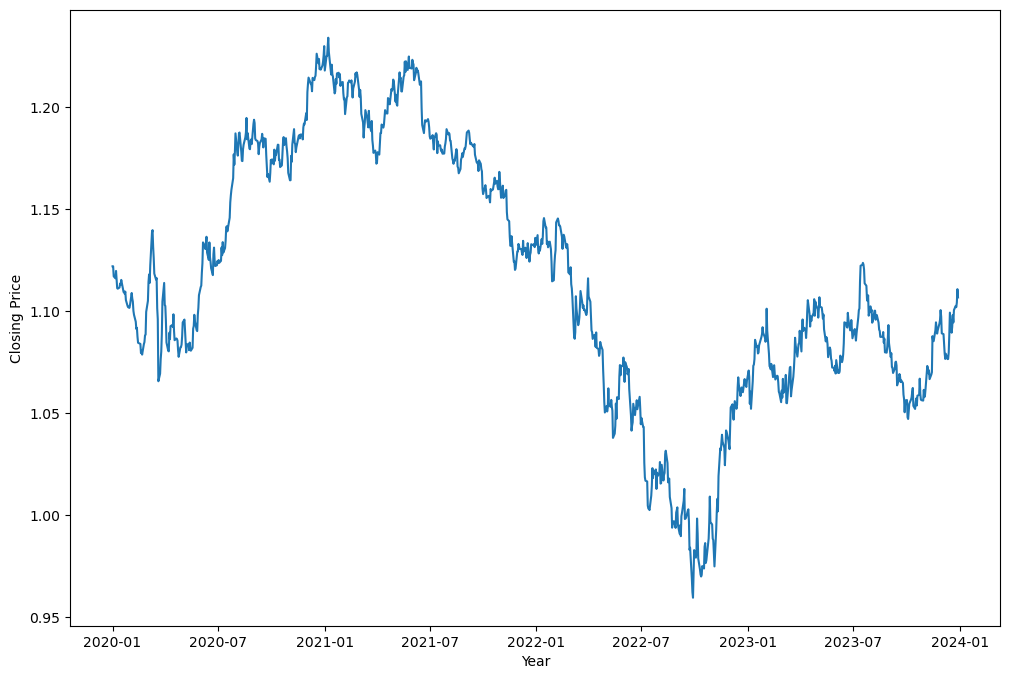

In [3]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(df.index, df['Close'], label='EUR USD')

ax.set_xlabel('Year')
ax.set_ylabel('Closing Price')

plt.show()

# x% line crossover of y day histogram

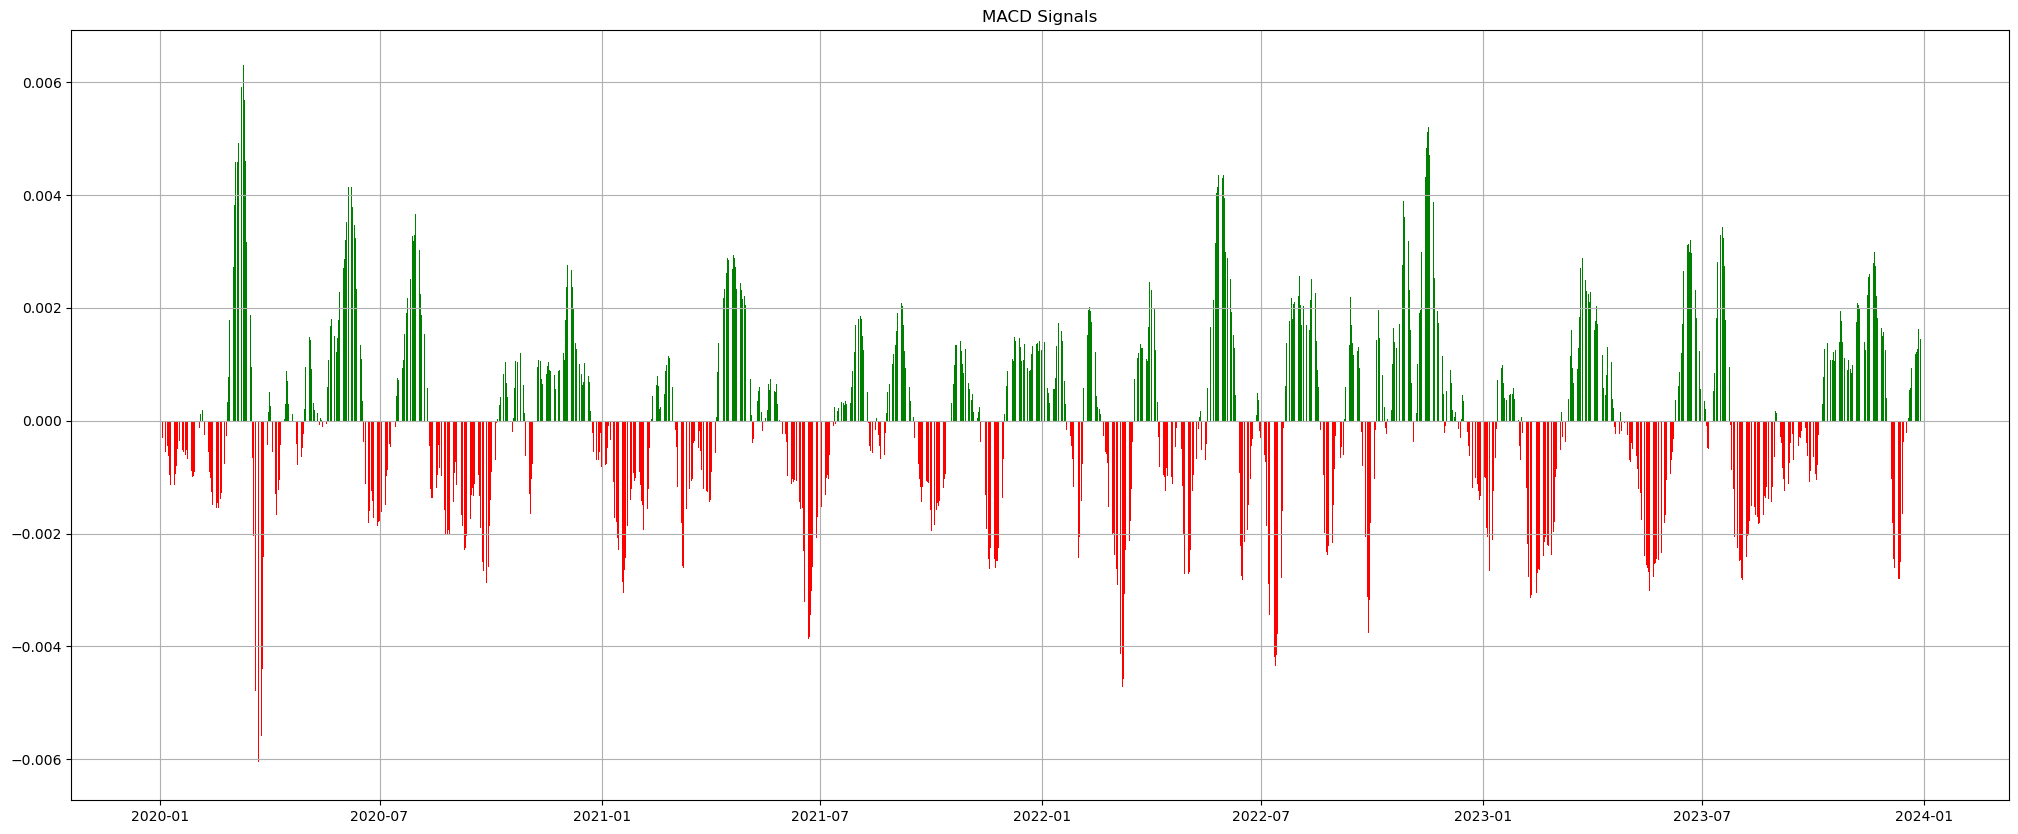

In [4]:
df1=df.copy()

ema12 = df1['Close'].ewm(span=12, adjust=False).mean()
ema26 = df1['Close'].ewm(span=26, adjust=False).mean()
macd_line = ema12 - ema26

signal_line = macd_line.ewm(span=9, adjust=False).mean()

histogram = macd_line - signal_line

df1['histogram'] = macd_line - signal_line

plt.figure(figsize=(25,10))

plt.bar(df.index, histogram, label='MACD - Signal',color=np.where(histogram < 0, 'red', 'green'))
plt.title("MACD Signals")
plt.grid(True)

plt.show()

In [5]:
def strat(df,lookback,pct):
    
    signal=[]
    signall = 0
    signals = 0
    buy_price=[]
    sell_price=[]
    position=[]
    for i in range(len(df)):
        maxx = df['histogram'][i-lookback:i].max()
        minn = df['histogram'][i-lookback:i].min()
        if df['histogram'][i] > pct*maxx:
            if signall!=1:
                signal.append(1)
                signall=1
                signals=0
                buy_price.append(df['Close'][i])
                sell_price.append(np.nan)
                position.append("long")
            else:
                signal.append(0)
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                position.append(np.nan)
        elif df['histogram'][i] < pct*minn:
            if signals!=-1:
                signal.append(-1)
                signals=-1
                signall=0
                buy_price.append(np.nan)
                sell_price.append(df['Close'][i])
                position.append("short")
            else:
                signal.append(0)
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                position.append(np.nan)
        else:
            signall=0
            signals=0
            signal.append(0)
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            position.append(np.nan)
            
    return signal,buy_price,sell_price,position

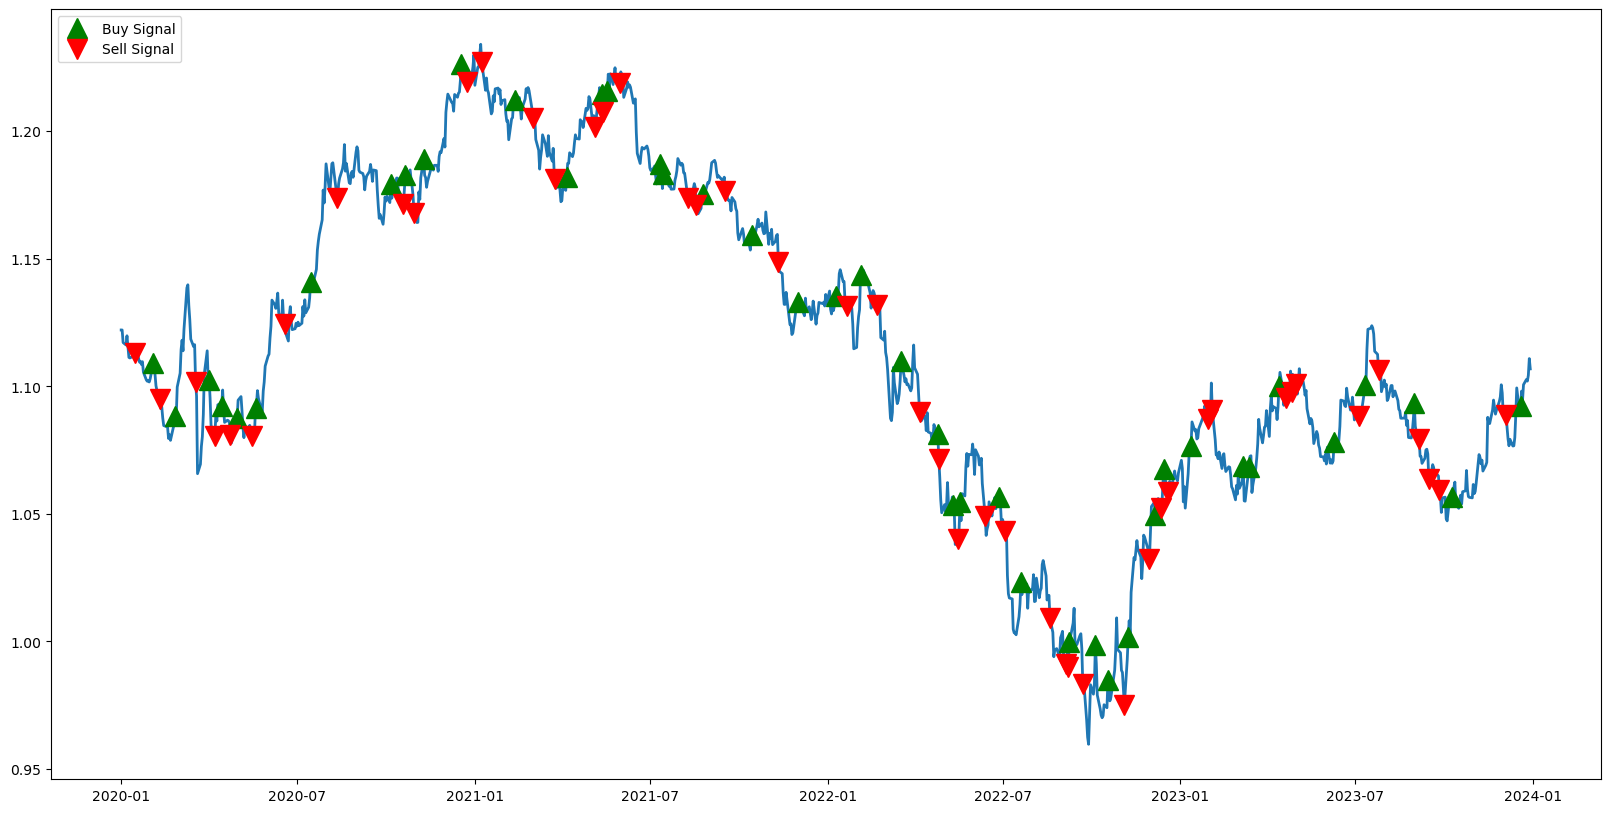

In [6]:
signal,buy_price,sell_price,position = strat(df1,10,.25)
df1['signal']=signal
df1['buy_price']=buy_price
df1['sell_price']=sell_price
df1['position']=position

plt.figure(figsize=(20,10))

plt.plot(df1['Close'], linewidth = 2)
plt.plot(df1.index, buy_price, marker = '^', color = 'green', markersize = 15, linewidth = 0, label = 'Buy Signal')
plt.plot(df1.index, sell_price, marker = 'v', color= 'r', markersize = 15, linewidth = 0, label = 'Sell Signal')
plt.legend(loc = 'upper left')
plt.show()

In [7]:
def capx(df,cap,lot):
    capital=[100000]
    
    buyx=0
    sellx=0
    buypx=0
    sellpx=0
    buyp=0
    sellp=0
    pos_type=[]
    for i in range(len(df)):
        if not pd.isna(df['buy_price'][i]):
            if sellx==1:                       #closing sell position
                capital.append(capital[-1])
                sellx=0
                sellpx=0
                sellp=0
                pos_type.append("close")
                cap=capital[-1]
            else:                              #opening buy position
                capital.append(capital[-1])
                buypx=buypx+1
                if buypx==1:
                    buyp=df['Close'][i]
                    cap=cap-(buyp*lot)
                    buyx=1
                elif buypx>1 :                           #to keep count of more than 1 positions
                    buyp=(buyp+df['Close'][i])
                    cap=cap-(buyp*lot/buypx)
                    buyx=1
                pos_type.append("open")
                
            
        elif not pd.isna(df['sell_price'][i]):
            if buyx==1:
                capital.append(capital[-1])
                buyx=0
                buypx=0
                buyp=0
                pos_type.append("close")
                cap=capital[-1]
            else:
                capital.append(capital[-1])
                sellpx=sellpx+1
                if sellpx==1:
                    sellp=df['Close'][i]
                    cap=cap+(sellp*lot)
                    sellx=1
                elif sellpx>1:
                    sellp=(sellp+df['Close'][i])
                    cap=cap+(sellp*lot/sellpx)
                    sellx=1
                pos_type.append("open")
            
        elif buyx==1:
            capital.append(cap+(df['Close'][i]*lot*buypx))
            pos_type.append(np.nan)
        elif sellx==1:
            capital.append(cap-(df['Close'][i]*lot*sellpx))
            pos_type.append(np.nan)
        else:
            capital.append(capital[-1])
            cap=capital[-1]
            pos_type.append(np.nan)
    del capital[0]
    return capital,pos_type

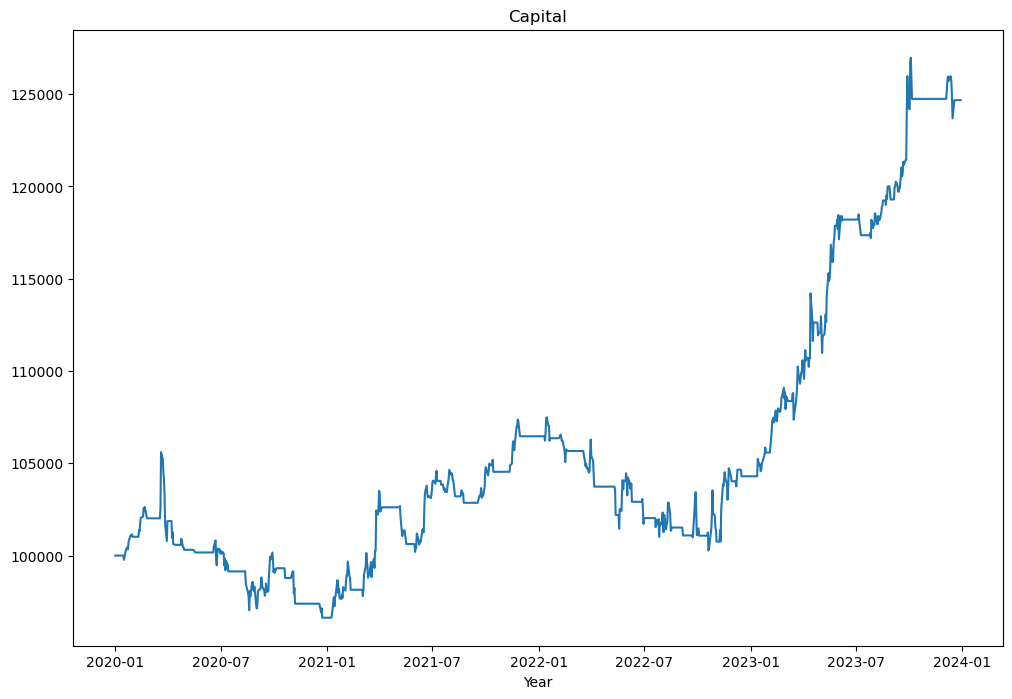

In [8]:
capital,pos_type = capx(df1,100000,100000)
df1['capital']=capital
df1['pos_type']=pos_type

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(df1.index, df1['capital'], label='EUR USD')

ax.set_xlabel('Year')
plt.title("Capital")

plt.show()

# to give an idea of how multiple positions are opening and then closing

In [9]:
df1[-85:-35]

,Open,High,Low,Close,Adj Close,Volume,histogram,signal,buy_price,sell_price,position,capital,pos_type
Date,,,,,,,,,,,,,
2023-09-04,1.077586,1.080906,1.077400,1.077586,1.077586,0,-0.000292,0,NaN,NaN,NaN,119295.752048,NaN
2023-09-05,1.079447,1.079914,1.070755,1.079447,1.079447,0,-0.000389,-1,NaN,1.079447,short,119295.752048,open
2023-09-06,1.072616,1.074818,1.070515,1.072616,1.072616,0,-0.000830,0,NaN,NaN,NaN,119978.868961,NaN
2023-09-07,1.072420,1.073422,1.068764,1.072420,1.072420,0,-0.001036,0,NaN,NaN,NaN,119998.431206,NaN
2023-09-08,1.069782,1.074206,1.069507,1.069782,1.069782,0,-0.001239,0,NaN,NaN,NaN,120262.289047,NaN
2023-09-11,1.071811,1.075685,1.071146,1.071811,1.071811,0,-0.001128,0,NaN,NaN,NaN,120059.347153,NaN
2023-09-12,1.075038,1.076264,1.070618,1.075038,1.075038,0,-0.000747,0,NaN,NaN,NaN,119736.719131,NaN
2023-09-13,1.075327,1.076542,1.071742,1.075327,1.075327,0,-0.000403,0,NaN,NaN,NaN,119707.810879,NaN
2023-09-14,1.073422,1.075500,1.065507,1.073422,1.073422,0,-0.000239,0,NaN,NaN,NaN,119898.271561,NaN


# coppock curve

In [10]:
def coppock(df,lookback1,lookback2,lookback3):
    def wma_gen(df, lookback1):
        lookbackx = list(range(1,lookback1+1))
        weights = [w / sum(lookbackx) for w in lookbackx]
    
        def weighted_moving_average(values):
            return sum(weights[i] * values[i] for i in range(len(weights)))
        wma = list(df['roc'].rolling(window=lookback1).apply(weighted_moving_average, raw=True))
        return wma
    
    roc1=[]
    for i in range(len(df)):
        if i>lookback2:
            rocx = (df['Close'][i] - df['Close'][i - lookback2]) / df['Close'][i - lookback2]
            roc1.append(rocx)
        else:
            roc1.append(np.nan)
    roc2=[]
    for i in range(len(df)):
        if i>lookback3:
            rocx = (df['Close'][i] - df['Close'][i - lookback3]) / df['Close'][i - lookback3]
            roc2.append(rocx)
        else:
            roc2.append(np.nan)
    rocz=[]
    for i in range(len(roc1)):
        rocz.append(roc1[i]+roc2[i])
    df['roc']=rocz
    
    coppock=wma_gen(df,lookback1)
    return coppock

In [11]:
df2=df.copy()
coppock=coppock(df2,4,14,11)
df2['coppock']=coppock
df2=df2.drop(columns=['roc'])
df2

,Open,High,Low,Close,Adj Close,Volume,coppock
Date,,,,,,,
2020-01-01,1.122083,1.122838,1.115947,1.122083,1.122083,0,NaN
2020-01-02,1.121894,1.122712,1.116682,1.122083,1.122083,0,NaN
2020-01-03,1.117081,1.118068,1.112570,1.117144,1.117144,0,NaN
2020-01-06,1.116246,1.120825,1.115810,1.116196,1.116196,0,NaN
2020-01-07,1.119583,1.119946,1.113487,1.119799,1.119799,0,NaN
...,...,...,...,...,...,...,...
2023-12-25,1.102657,1.104240,1.099989,1.102657,1.102657,0,0.030775
2023-12-26,1.102026,1.103997,1.100958,1.102026,1.102026,0,0.038114
2023-12-27,1.104301,1.112248,1.102925,1.104301,1.104301,0,0.045063


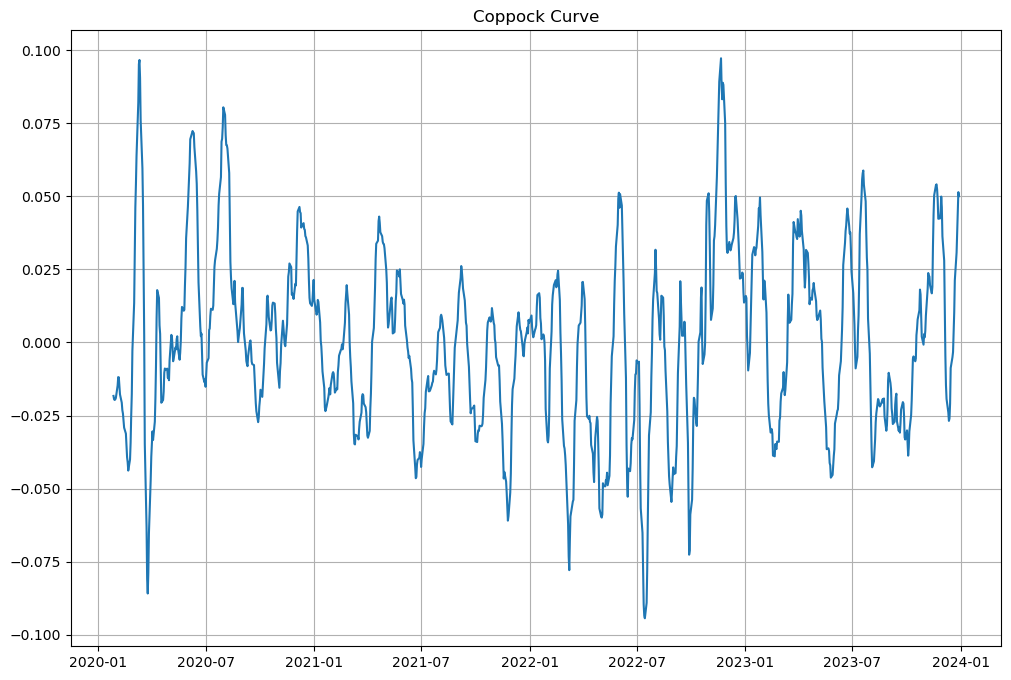

In [12]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(df2.index, df2['coppock'], label='EUR USD')
plt.title("Coppock Curve")
plt.grid(True)

plt.show()

In [13]:
def strat_coppock(df):
    
    signal=[]
    signall = 0
    signals = 0
    buy_price=[]
    sell_price=[]
    position=[]
    for i in range(len(df)):
        if df['coppock'][i] > 0:
            if signall!=1:
                signal.append(1)
                signall=1
                signals=0
                buy_price.append(df['Close'][i])
                sell_price.append(np.nan)
                position.append("long")
            else:
                signal.append(0)
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                position.append(np.nan)
        elif df['coppock'][i] < 0:
            if signals!=-1:
                signal.append(-1)
                signals=-1
                signall=0
                buy_price.append(np.nan)
                sell_price.append(df['Close'][i])
                position.append("short")
            else:
                signal.append(0)
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                position.append(np.nan)
        else:
            signall=0
            signals=0
            signal.append(0)
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            position.append(np.nan)
            
    return signal,buy_price,sell_price,position

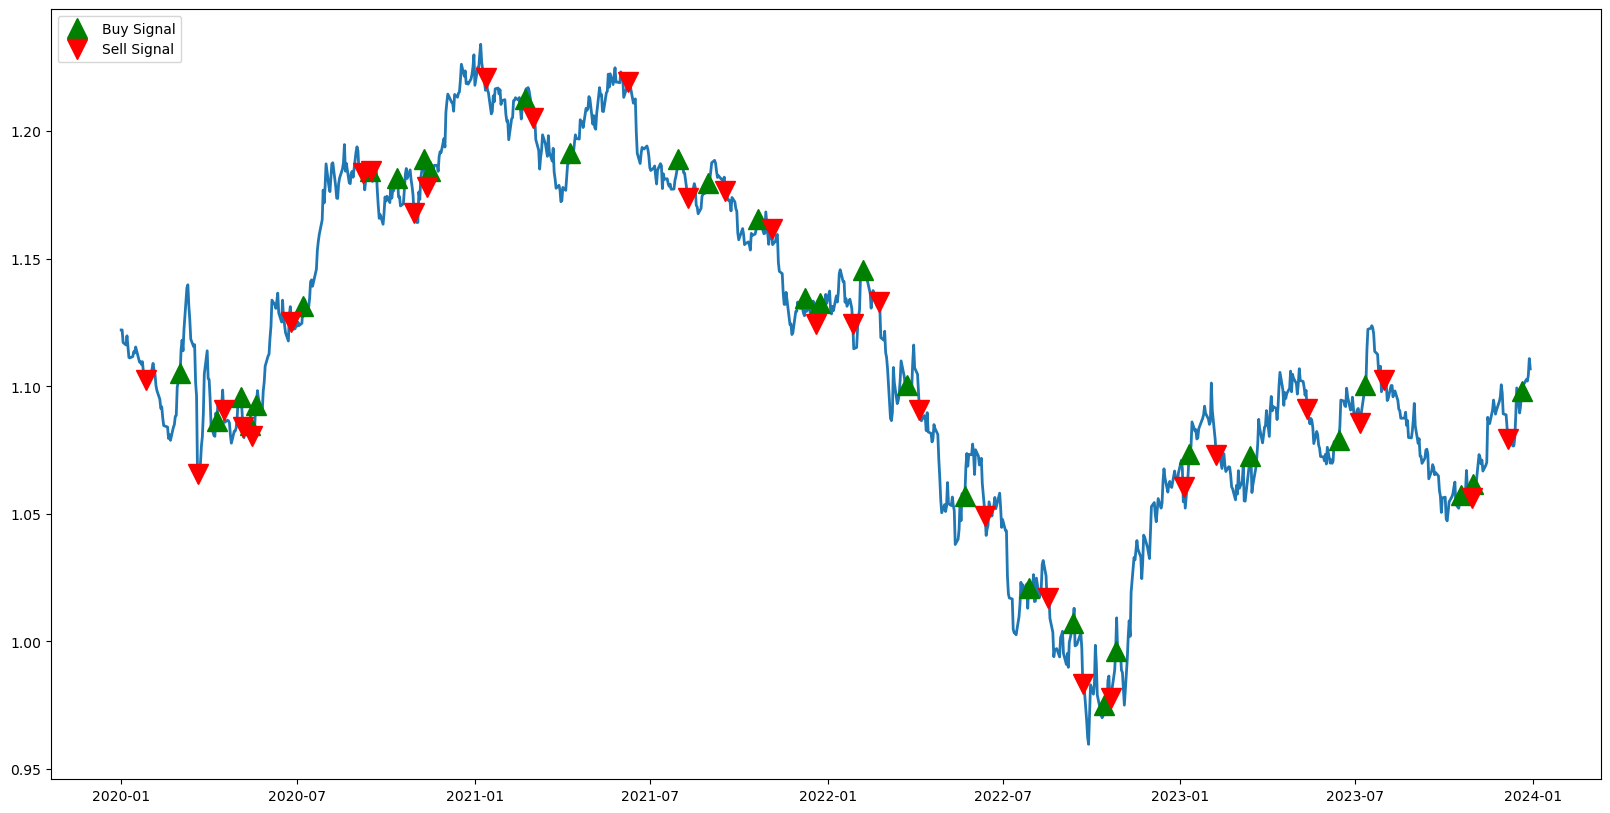

In [14]:
signal,buy_price,sell_price,position=strat_coppock(df2)

df2['signal']=signal
df2['buy_price']=buy_price
df2['sell_price']=sell_price
df2['position']=position

plt.figure(figsize=(20,10))

plt.plot(df2['Close'], linewidth = 2)
plt.plot(df2.index, buy_price, marker = '^', color = 'green', markersize = 15, linewidth = 0, label = 'Buy Signal')
plt.plot(df2.index, sell_price, marker = 'v', color= 'r', markersize = 15, linewidth = 0, label = 'Sell Signal')
plt.legend(loc = 'upper left')
plt.show()

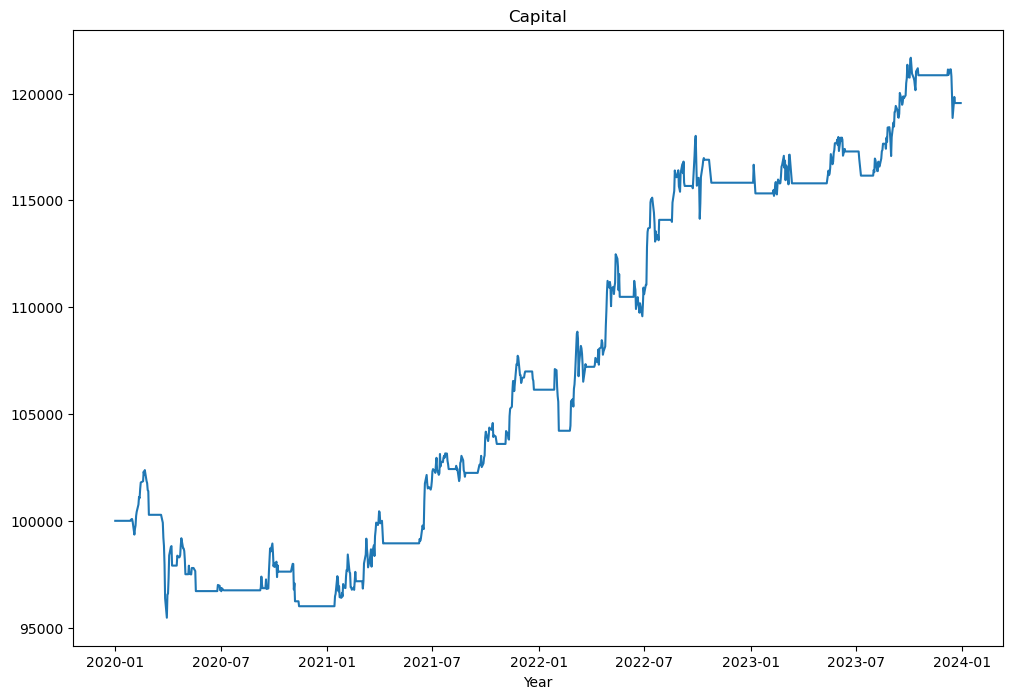

In [15]:
capital,pos_type = capx(df2,100000,100000)
df2['capital']=capital
df2['pos_type']=pos_type

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(df2.index, df2['capital'], label='EUR USD')

ax.set_xlabel('Year')
plt.title("Capital")

plt.show()

# this strategy is based on standard deviation of prices to basically form a momentum strategy

I have generated buy signal if the mean value of close price of today and yesterday is more than mean value of close price of 3 days before yesterday added with the standard deviation of these 3 days.

I have thought of this in an effort to identify the momentum of the price.

Right now I have dealt with data of daily timeframe...later we can modify it.

In [16]:
def strat_std_dev(df):
    
    signal=[]
    signall = 0
    signals = 0
    buy_price=[]
    sell_price=[]
    position=[]
    
    #df['volatility'] = df['Close'].rolling(window = 5).std()    # i have calculated the volatility usind std deviation of 5 days
    #df['volatility'] = df['volatility'].apply(lambda x: ((x-df['volatility'].min())/(df['volatility'].max()-df['volatility'].min()))*100)
    
    # i have scaled down the standard deviation terms to a scale of 0-100
    # this scale i have termed as volatility
    
    for i in range(len(df)):
        if i>4:
            data1 = [df['Close'][i],df['Close'][i-1]]
            data2 = [df['Close'][i-2],df['Close'][i-3],df['Close'][i-4]]
            if (np.mean(data1)) > (np.mean(data2))+(2*(np.std(data2))):
                if signall!=1:
                    signal.append(1)
                    signall=1
                    signals=0
                    buy_price.append(df['Close'][i])
                    sell_price.append(np.nan)
                    position.append("long")
                else:
                    signal.append(0)
                    buy_price.append(np.nan)
                    sell_price.append(np.nan)
                    position.append(np.nan)
            elif (np.mean(data1)) < (np.mean(data2))+(2*(np.std(data2))):
                if signals!=-1:
                    signal.append(-1)
                    signals=-1
                    signall=0
                    buy_price.append(np.nan)
                    sell_price.append(df['Close'][i])
                    position.append("short")
                else:
                    signal.append(0)
                    buy_price.append(np.nan)
                    sell_price.append(np.nan)
                    position.append(np.nan)
            else:
                signall=0
                signals=0
                signal.append(0)
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                position.append(np.nan)
        else:
            signal.append(0)
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            position.append(np.nan)
            
    return signal,buy_price,sell_price,position

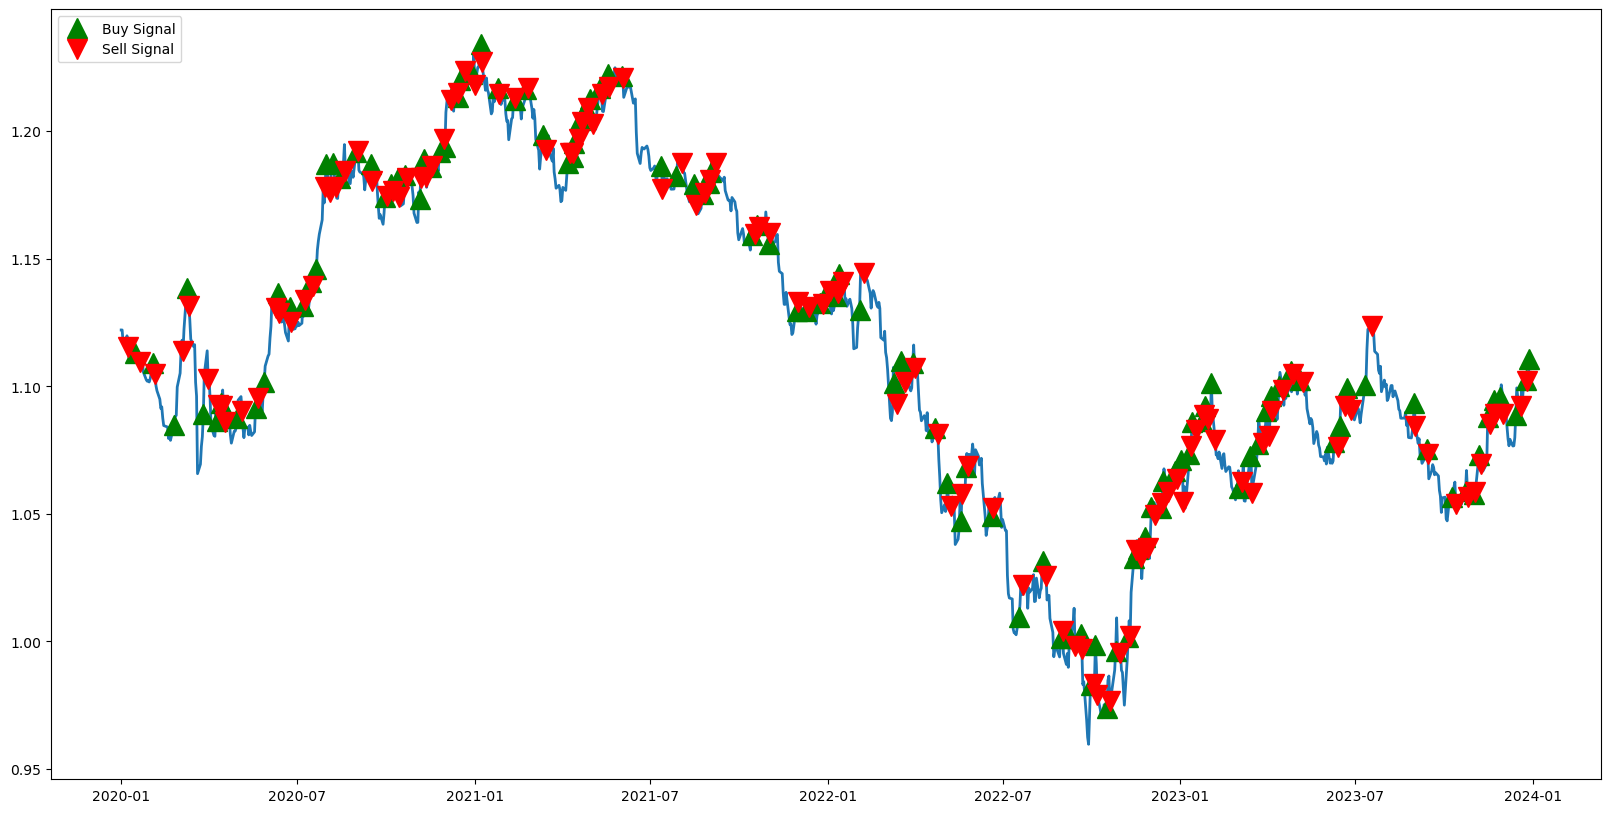

In [17]:
df3=df.copy()

signal,buy_price,sell_price,position=strat_std_dev(df3)

df3['signal']=signal
df3['buy_price']=buy_price
df3['sell_price']=sell_price
df3['position']=position

plt.figure(figsize=(20,10))

plt.plot(df3['Close'], linewidth = 2)
plt.plot(df3.index, buy_price, marker = '^', color = 'green', markersize = 15, linewidth = 0, label = 'Buy Signal')
plt.plot(df3.index, sell_price, marker = 'v', color= 'r', markersize = 15, linewidth = 0, label = 'Sell Signal')
plt.legend(loc = 'upper left')
plt.show()

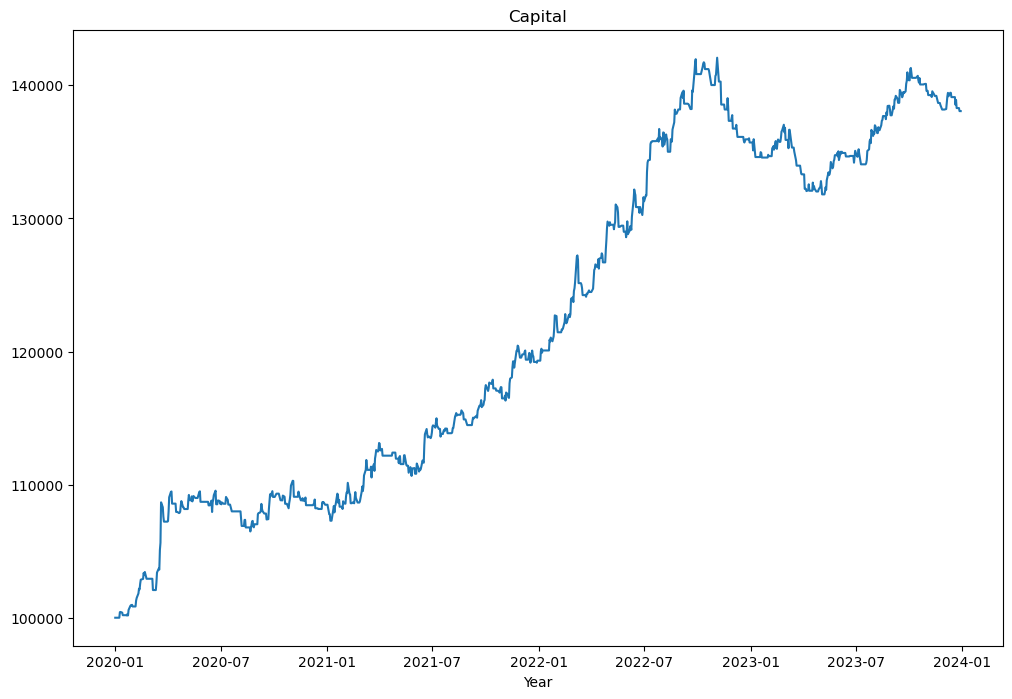

In [18]:
capital,pos_type = capx(df3,100000,100000)
df3['capital']=capital
df3['pos_type']=pos_type

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(df3.index, df3['capital'], label='EUR USD')

ax.set_xlabel('Year')
plt.title("Capital")

plt.show()

# percent difference from SMA of market price

In [19]:
def strat_sma_dev(df,lookback1):
    
    signal=[]
    signall = 0
    signals = 0
    buy_price=[]
    sell_price=[]
    position=[]
    
    df['sma']=df['Close'].rolling(lookback1).mean()
    for i in range(len(df)):
        if df['Close'][i] > 1.005*df['sma'][i]:
            if signall!=1:
                signal.append(1)
                signall=1
                signals=0
                buy_price.append(df['Close'][i])
                sell_price.append(np.nan)
                position.append("long")
            else:
                signal.append(0)
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                position.append(np.nan)
        elif df['Close'][i] < .985*df['sma'][i]:
            if signals!=-1:
                signal.append(-1)
                signals=-1
                signall=0
                buy_price.append(np.nan)
                sell_price.append(df['Close'][i])
                position.append("short")
            else:
                signal.append(0)
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                position.append(np.nan)
        else:
            signall=0
            signals=0
            signal.append(0)
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            position.append(np.nan)
            
    return signal,buy_price,sell_price,position

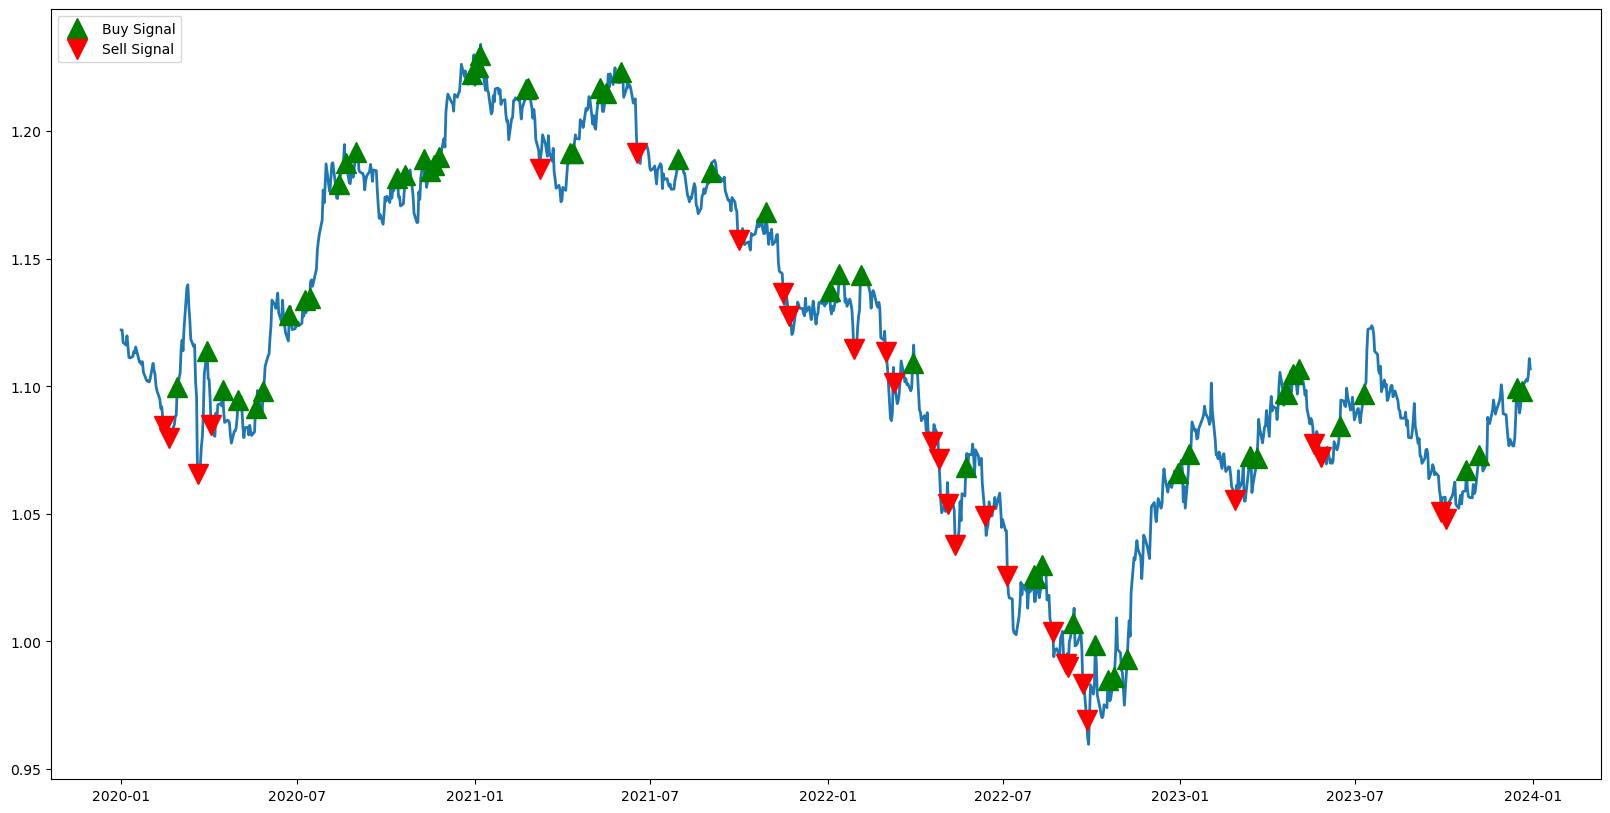

In [20]:
df4=df.copy()

signal,buy_price,sell_price,position=strat_sma_dev(df4,20)

df4['signal']=signal
df4['buy_price']=buy_price
df4['sell_price']=sell_price
df4['position']=position

plt.figure(figsize=(20,10))

plt.plot(df4['Close'], linewidth = 2)
plt.plot(df4.index, buy_price, marker = '^', color = 'green', markersize = 15, linewidth = 0, label = 'Buy Signal')
plt.plot(df4.index, sell_price, marker = 'v', color= 'r', markersize = 15, linewidth = 0, label = 'Sell Signal')
plt.legend(loc = 'upper left')
plt.show()

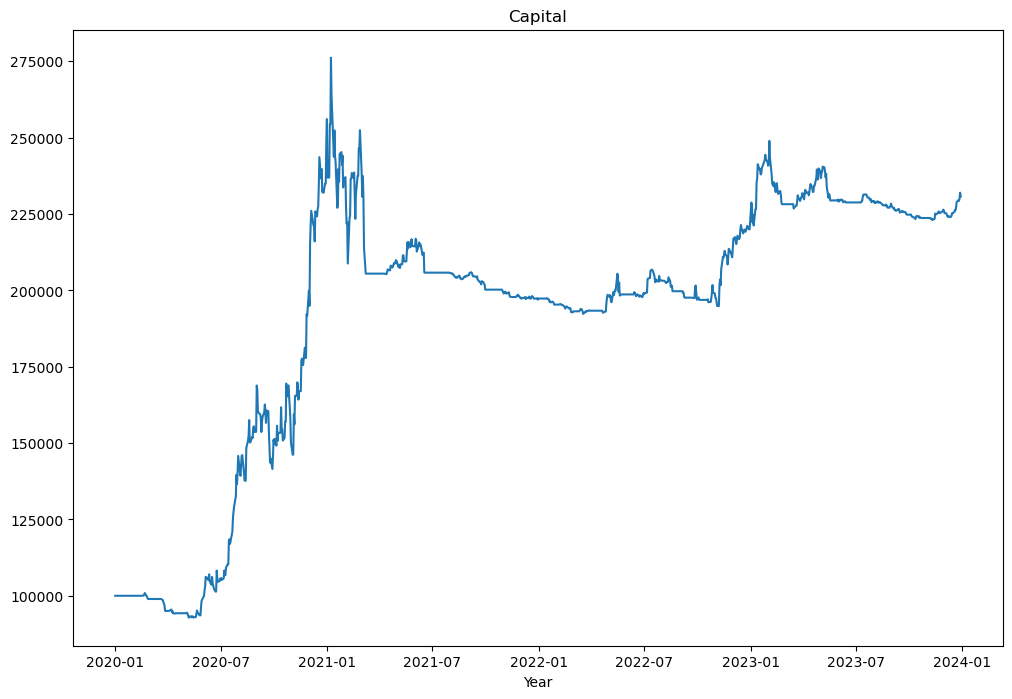

In [21]:
capital,pos_type = capx(df4,100000,100000)
df4['capital']=capital
df4['pos_type']=pos_type

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(df4.index, df4['capital'], label='EUR USD')

ax.set_xlabel('Year')
plt.title("Capital")

plt.show()

# Parabolic SAR

In [22]:
import ta
from ta.trend import PSARIndicator

In [23]:
df5=df.copy()

def psar(df,step,max_step):
    psar_indicator=PSARIndicator(df5.High, df5.Low, df5.Close,step= 0.02, max_step=0.2)
    df['psar']=psar_indicator.psar()
    return df

df5=psar(df5,.02,.2)

In [24]:
def strat_psar(df):
    
    signal=[]
    signall = 0
    signals = 0
    buy_price=[]
    sell_price=[]
    position=[]
    
    for i in range(len(df)):
        if df['Close'][i] > df['psar'][i]:
            if signall!=1:
                signal.append(1)
                signall=1
                signals=0
                buy_price.append(df['Close'][i])
                sell_price.append(np.nan)
                position.append("long")
            else:
                signal.append(0)
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                position.append(np.nan)
        elif df['Close'][i] < df['psar'][i]:
            if signals!=-1:
                signal.append(-1)
                signals=-1
                signall=0
                buy_price.append(np.nan)
                sell_price.append(df['Close'][i])
                position.append("short")
            else:
                signal.append(0)
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                position.append(np.nan)
        else:
            signall=0
            signals=0
            signal.append(0)
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            position.append(np.nan)
            
    return signal,buy_price,sell_price,position

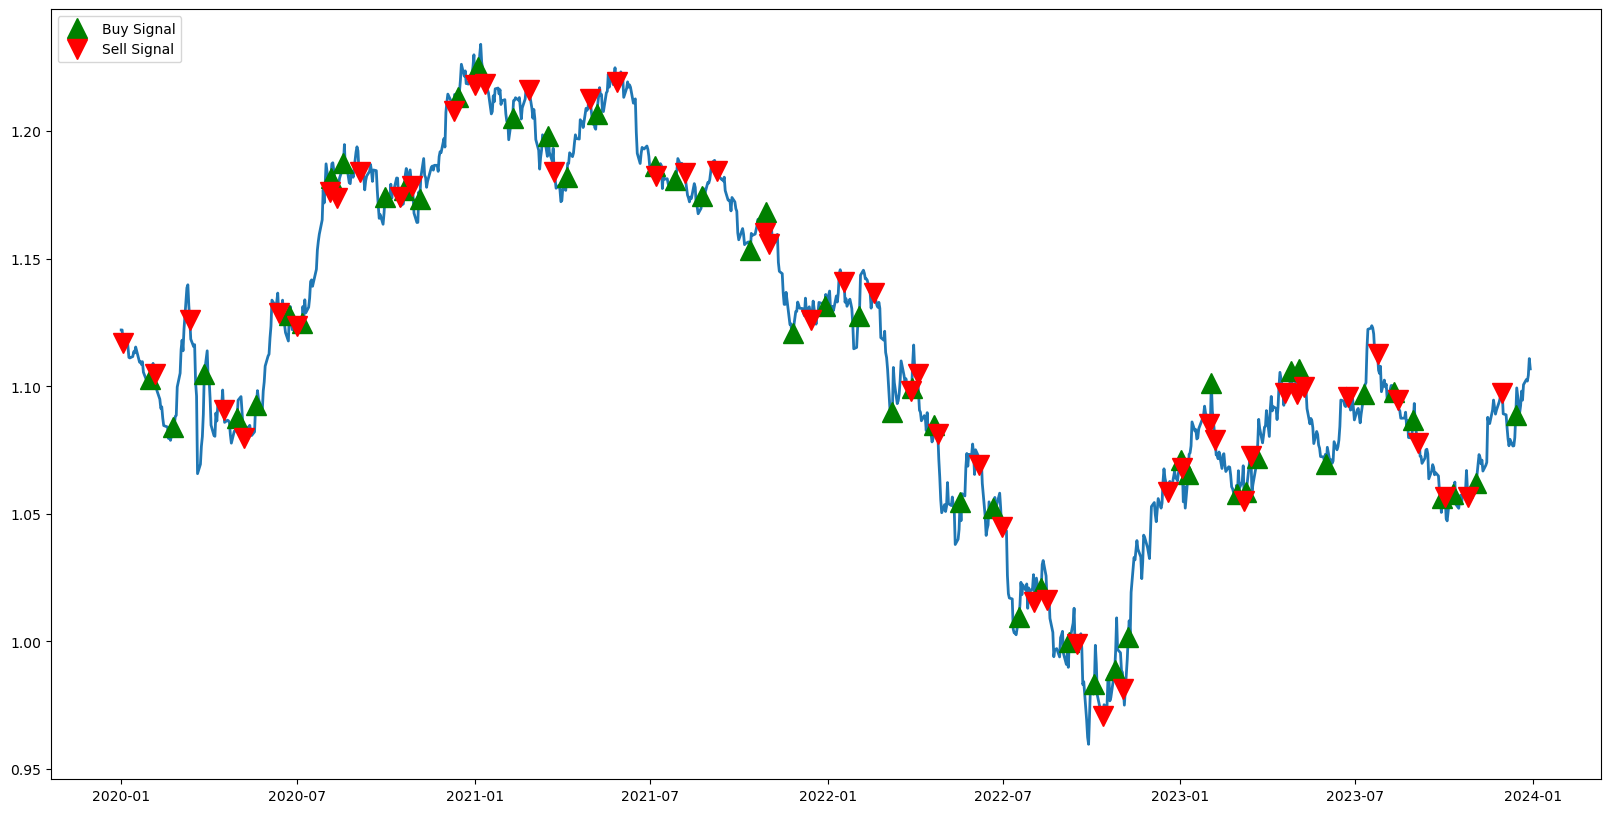

In [25]:
signal,buy_price,sell_price,position=strat_psar(df5)

df5['signal']=signal
df5['buy_price']=buy_price
df5['sell_price']=sell_price
df5['position']=position

plt.figure(figsize=(20,10))

plt.plot(df5['Close'], linewidth = 2)
plt.plot(df5.index, buy_price, marker = '^', color = 'green', markersize = 15, linewidth = 0, label = 'Buy Signal')
plt.plot(df5.index, sell_price, marker = 'v', color= 'r', markersize = 15, linewidth = 0, label = 'Sell Signal')
plt.legend(loc = 'upper left')
plt.show()

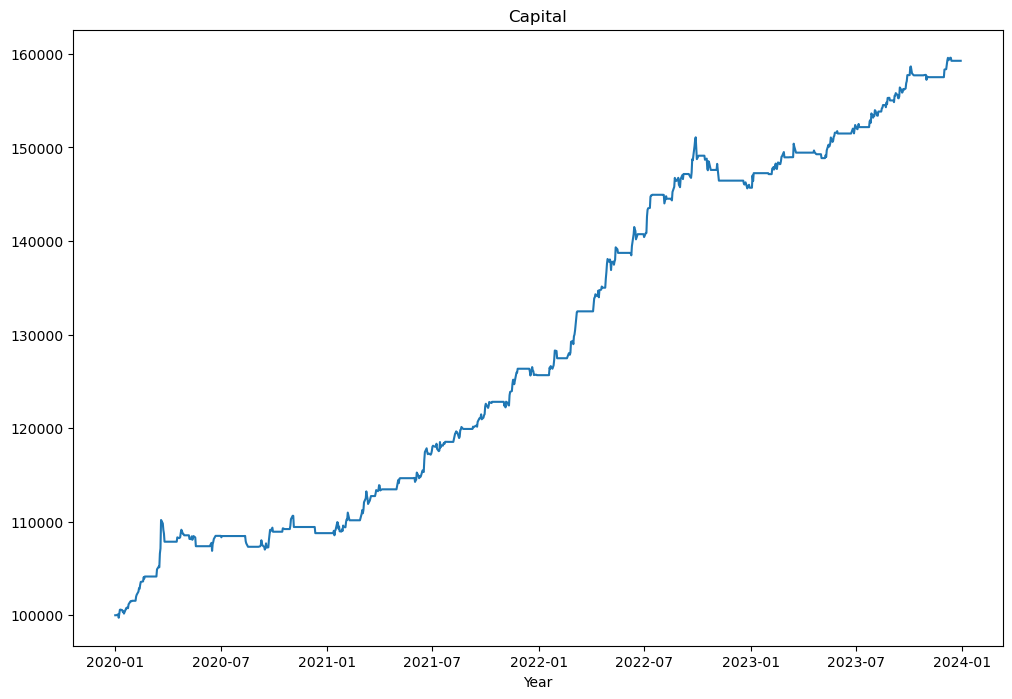

In [26]:
capital,pos_type = capx(df5,100000,100000)
df5['capital']=capital
df5['pos_type']=pos_type

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(df5.index, df5['capital'], label='EUR USD')

ax.set_xlabel('Year')
plt.title("Capital")

plt.show()

# hurst exponent

In [27]:
def get_hurst_exponent(ts, max_lag=20):
    lags = range(2, max_lag)
    tau = [np.std(np.subtract(ts[lag:], ts[:-lag])) for lag in lags]
    
    return np.polyfit(np.log(lags), np.log(tau), 1)[0]

In [28]:
df6=df.copy()

In [29]:
pip install hurst

Note: you may need to restart the kernel to use updated packages.


In [30]:
from hurst import compute_Hc

In [31]:
def hurst_exp(x):
    H,c,data = compute_Hc(x,kind='price',simplified=True)
    return H

hurst = df6['Close'].rolling(window=100).apply(hurst_exp, raw=False)
df6['hurst']=hurst

In [32]:
def strat_hurst(df):
    
    signal=[]
    signall = 0
    signals = 0
    buy_price=[]
    sell_price=[]
    position=[]
    
    for i in range(len(df)):
        if df['hurst'][i] > 0.6 or df['hurst'][i] < 0.4:
            if signall!=1:
                signal.append(1)
                signall=1
                signals=0
                buy_price.append(df['Close'][i])
                sell_price.append(np.nan)
                position.append("long")
            else:
                signal.append(0)
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                position.append(np.nan)
        elif df['hurst'][i] >0.4 and df['hurst'][i]<0.6:
            if signals!=-1:
                signal.append(-1)
                signals=-1
                signall=0
                buy_price.append(np.nan)
                sell_price.append(df['Close'][i])
                position.append("short")
            else:
                signal.append(0)
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                position.append(np.nan)
        else:
            signall=0
            signals=0
            signal.append(0)
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            position.append(np.nan)
            
    return signal,buy_price,sell_price,position

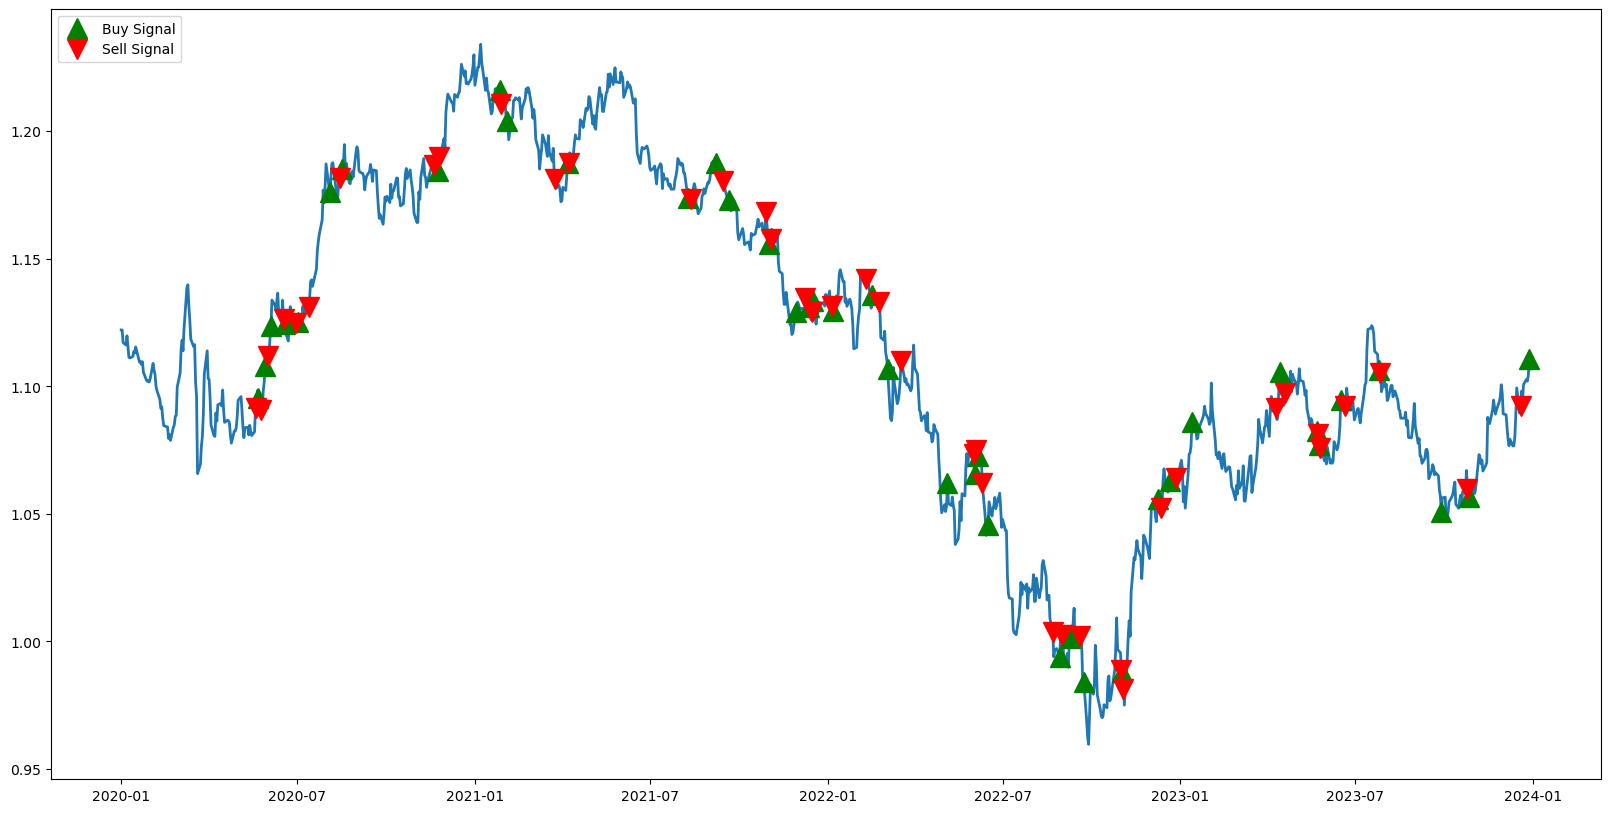

In [33]:
signal,buy_price,sell_price,position=strat_hurst(df6)

df6['signal']=signal
df6['buy_price']=buy_price
df6['sell_price']=sell_price
df6['position']=position

plt.figure(figsize=(20,10))

plt.plot(df6['Close'], linewidth = 2)
plt.plot(df6.index, buy_price, marker = '^', color = 'green', markersize = 15, linewidth = 0, label = 'Buy Signal')
plt.plot(df6.index, sell_price, marker = 'v', color= 'r', markersize = 15, linewidth = 0, label = 'Sell Signal')
plt.legend(loc = 'upper left')
plt.show()

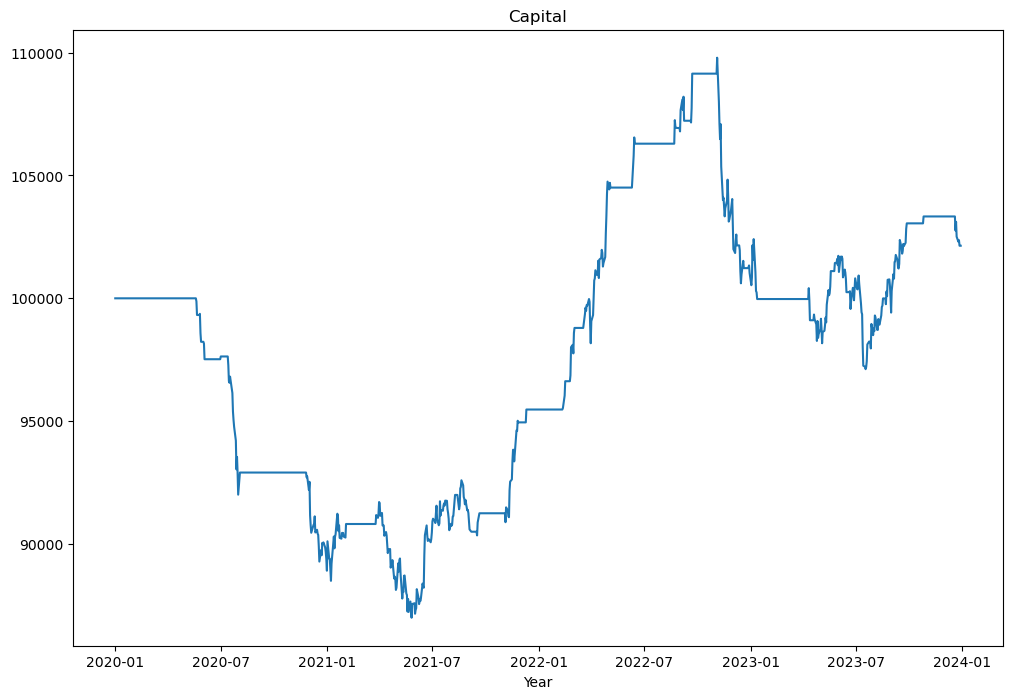

In [34]:
capital,pos_type = capx(df6,100000,100000)
df6['capital']=capital
df6['pos_type']=pos_type

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(df6.index, df6['capital'], label='EUR USD')

ax.set_xlabel('Year')
plt.title("Capital")

plt.show()

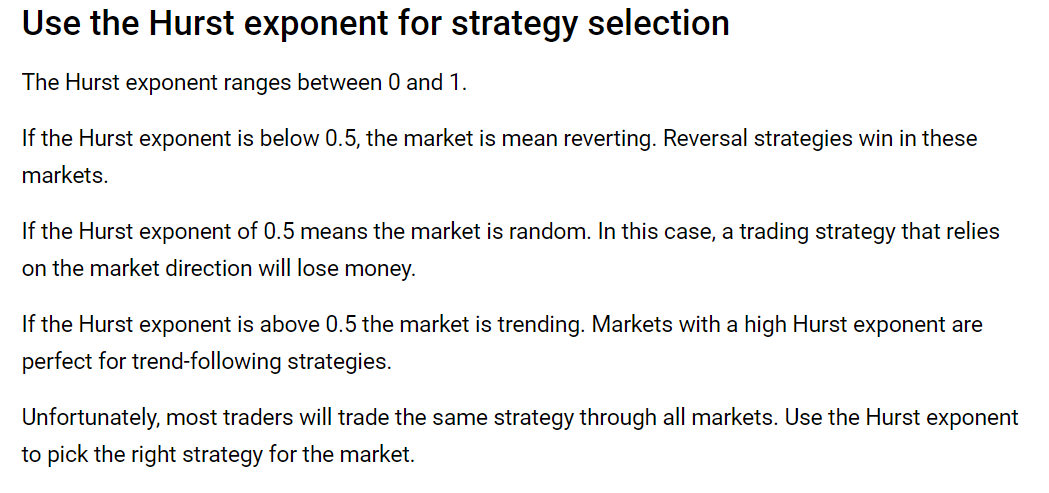

# ROC

In [35]:
df7=df.copy()
df7['roc']=df7['Close'].pct_change()

In [36]:
df7

,Open,High,Low,Close,Adj Close,Volume,roc
Date,,,,,,,
2020-01-01,1.122083,1.122838,1.115947,1.122083,1.122083,0,NaN
2020-01-02,1.121894,1.122712,1.116682,1.122083,1.122083,0,0.000000
2020-01-03,1.117081,1.118068,1.112570,1.117144,1.117144,0,-0.004401
2020-01-06,1.116246,1.120825,1.115810,1.116196,1.116196,0,-0.000848
2020-01-07,1.119583,1.119946,1.113487,1.119799,1.119799,0,0.003228
...,...,...,...,...,...,...,...
2023-12-25,1.102657,1.104240,1.099989,1.102657,1.102657,0,0.001852
2023-12-26,1.102026,1.103997,1.100958,1.102026,1.102026,0,-0.000573
2023-12-27,1.104301,1.112248,1.102925,1.104301,1.104301,0,0.002065


In [37]:
def strat_roc(df):
    
    signal=[]
    signall = 0
    signals = 0
    buy_price=[]
    sell_price=[]
    position=[]
    
    for i in range(len(df)):
        if df['roc'][i] > 0.0085:
            if signall!=1:
                signal.append(1)
                signall=1
                signals=0
                buy_price.append(df['Close'][i])
                sell_price.append(np.nan)
                position.append("long")
            else:
                signal.append(0)
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                position.append(np.nan)
        elif df['roc'][i] <0.0075:
            if signals!=-1:
                signal.append(-1)
                signals=-1
                signall=0
                buy_price.append(np.nan)
                sell_price.append(df['Close'][i])
                position.append("short")
            else:
                signal.append(0)
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                position.append(np.nan)
        else:
            signall=0
            signals=0
            signal.append(0)
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            position.append(np.nan)
            
    return signal,buy_price,sell_price,position

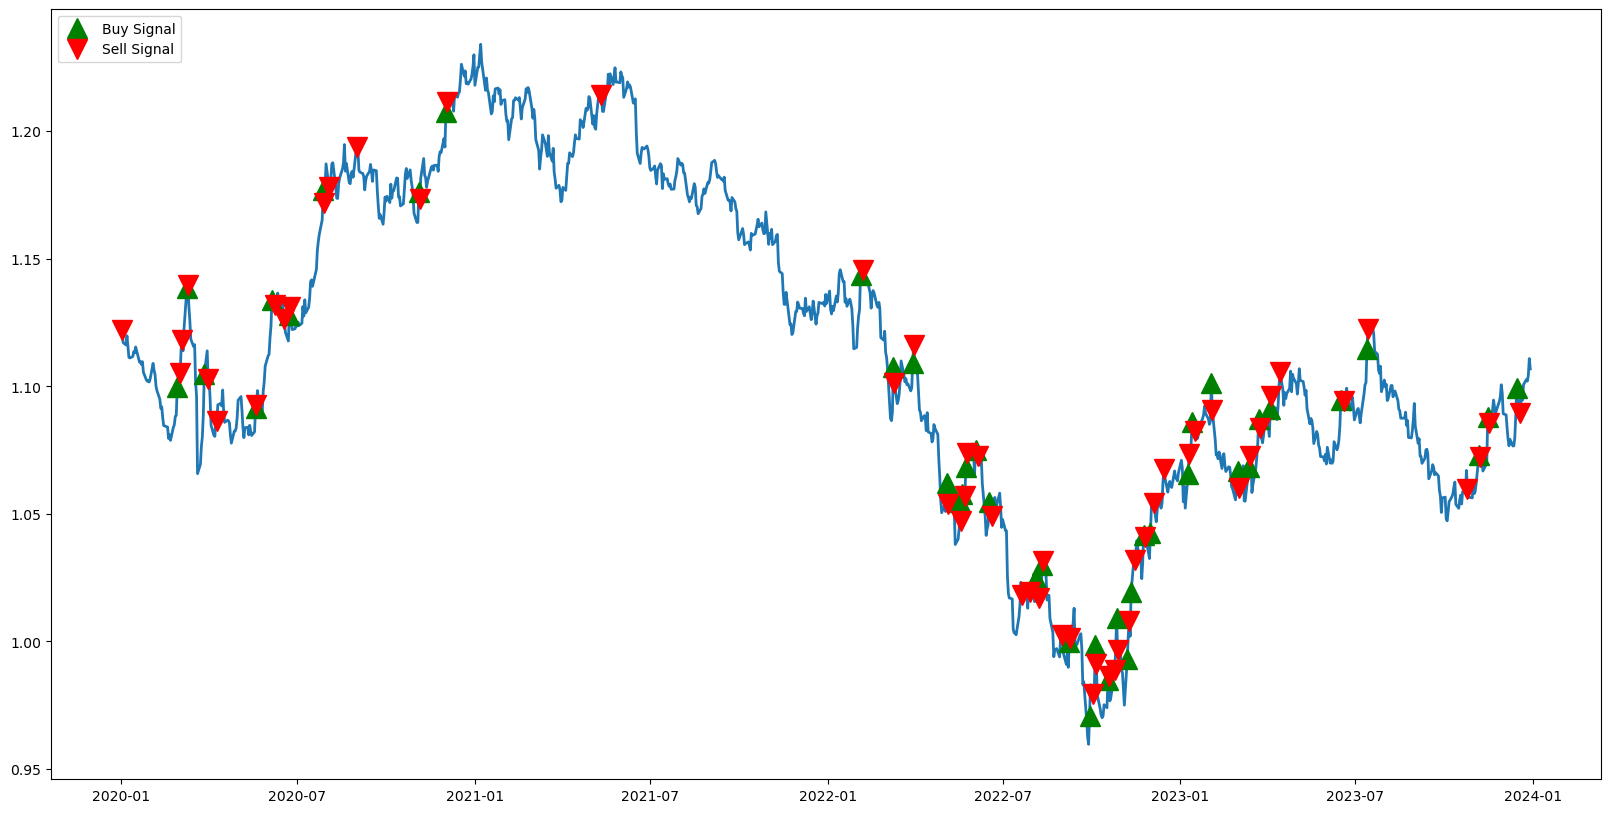

In [38]:
signal,buy_price,sell_price,position=strat_roc(df7)

df7['signal']=signal
df7['buy_price']=buy_price
df7['sell_price']=sell_price
df7['position']=position

plt.figure(figsize=(20,10))

plt.plot(df7['Close'], linewidth = 2)
plt.plot(df7.index, buy_price, marker = '^', color = 'green', markersize = 15, linewidth = 0, label = 'Buy Signal')
plt.plot(df7.index, sell_price, marker = 'v', color= 'r', markersize = 15, linewidth = 0, label = 'Sell Signal')
plt.legend(loc = 'upper left')
plt.show()

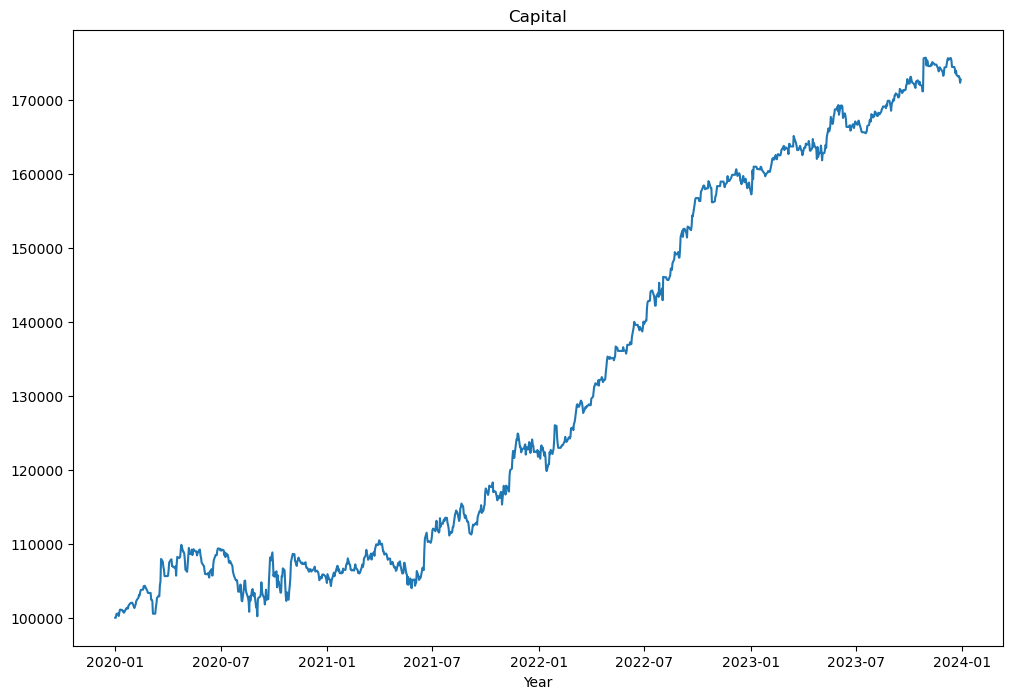

In [39]:
capital,pos_type = capx(df7,100000,100000)
df7['capital']=capital
df7['pos_type']=pos_type

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(df7.index, df7['capital'], label='EUR USD')

ax.set_xlabel('Year')
plt.title("Capital")

plt.show()

# RSI

In [40]:
from ta.momentum import RSIIndicator

df8=df.copy()
rsi_indicator = RSIIndicator(df8['Close'], window=14)
df8['rsi'] = rsi_indicator.rsi()

In [41]:
def strat_rsi(df):
    
    signal=[]
    signall = 0
    signals = 0
    buy_price=[]
    sell_price=[]
    position=[]
    
    for i in range(len(df)):
        if df['rsi'][i] < 30:
            if signall!=1:
                signal.append(1)
                signall=1
                signals=0
                buy_price.append(df['Close'][i])
                sell_price.append(np.nan)
                position.append("long")
            else:
                signal.append(0)
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                position.append(np.nan)
        elif df['rsi'][i] > 70:
            if signals!=-1:
                signal.append(-1)
                signals=-1
                signall=0
                buy_price.append(np.nan)
                sell_price.append(df['Close'][i])
                position.append("short")
            else:
                signal.append(0)
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                position.append(np.nan)
        else:
            signall=0
            signals=0
            signal.append(0)
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            position.append(np.nan)
            
    return signal,buy_price,sell_price,position

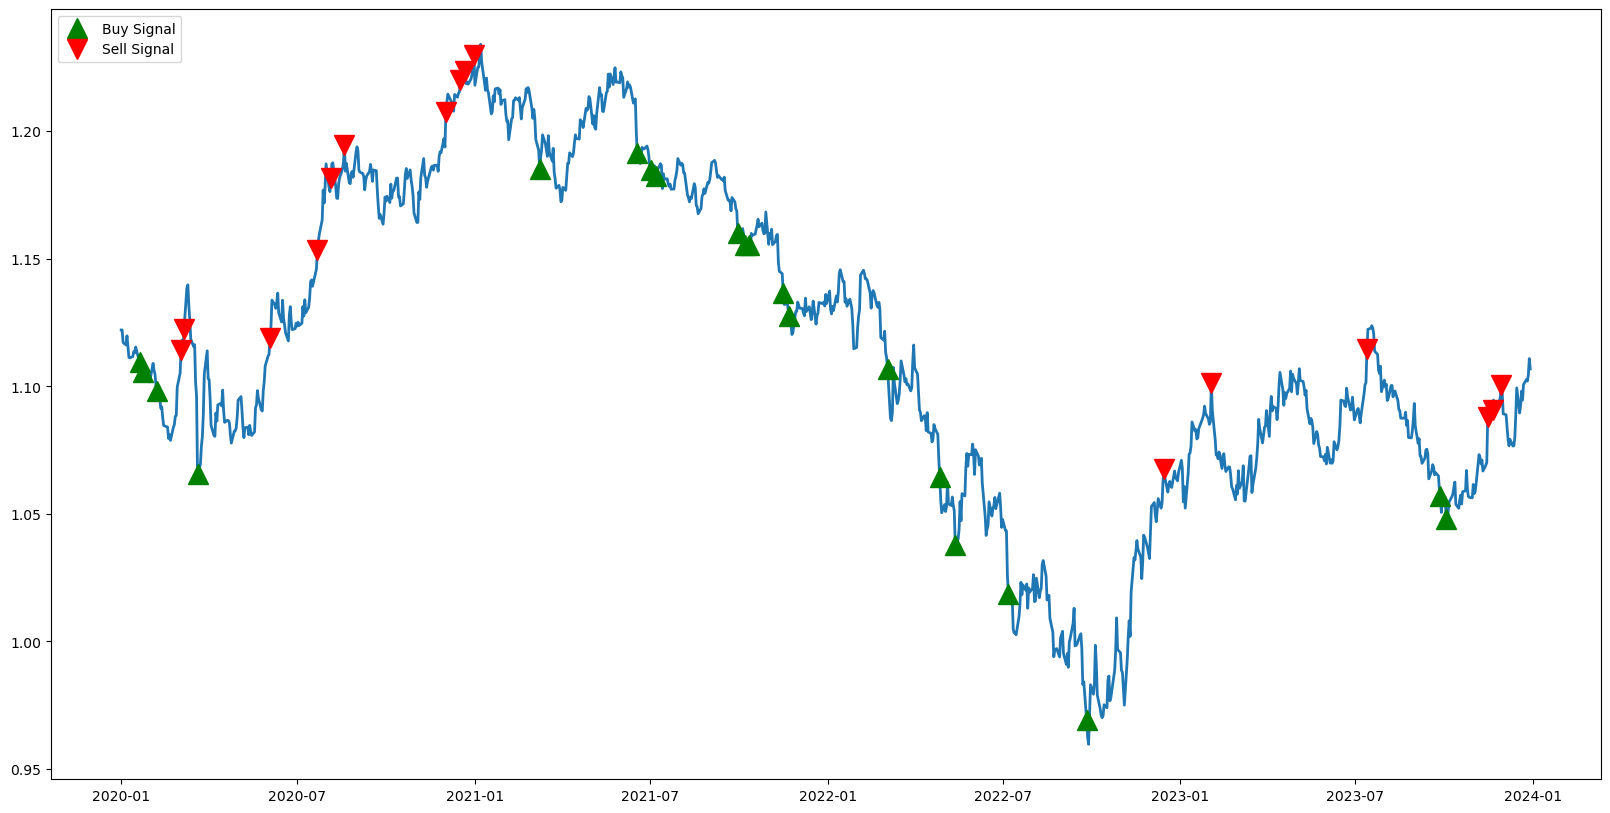

In [42]:
signal,buy_price,sell_price,position=strat_rsi(df8)

df8['signal']=signal
df8['buy_price']=buy_price
df8['sell_price']=sell_price
df8['position']=position

plt.figure(figsize=(20,10))

plt.plot(df8['Close'], linewidth = 2)
plt.plot(df8.index, buy_price, marker = '^', color = 'green', markersize = 15, linewidth = 0, label = 'Buy Signal')
plt.plot(df8.index, sell_price, marker = 'v', color= 'r', markersize = 15, linewidth = 0, label = 'Sell Signal')
plt.legend(loc = 'upper left')
plt.show()

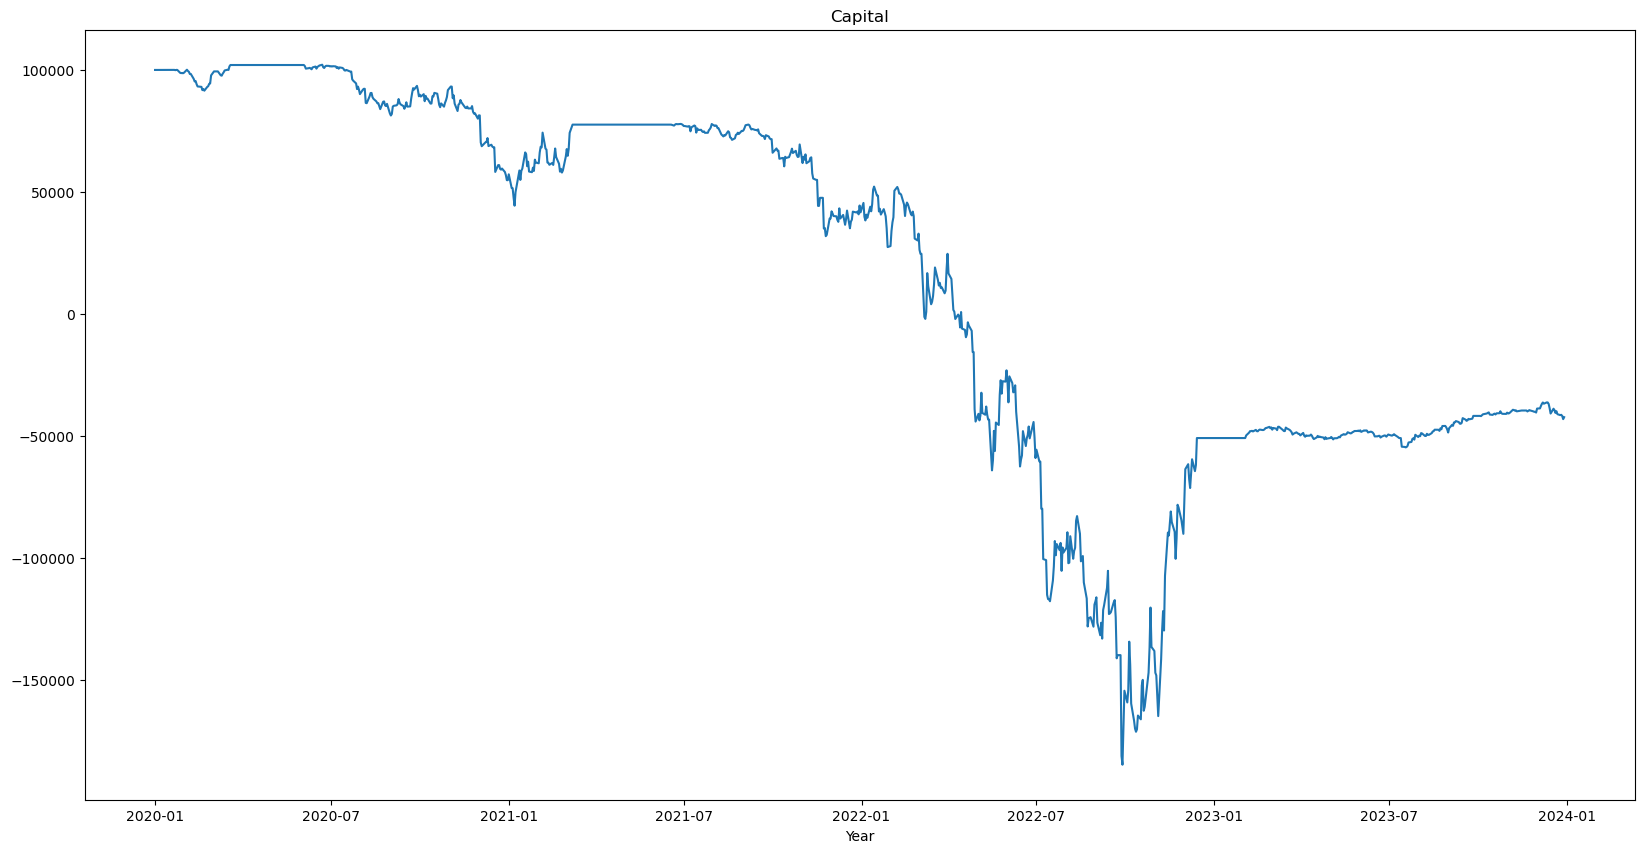

In [43]:
capital,pos_type = capx(df8,100000,100000)
df8['capital']=capital
df8['pos_type']=pos_type

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df8.index, df8['capital'], label='EUR USD')

ax.set_xlabel('Year')
plt.title("Capital")

plt.show()

# Peak/Bottom of MACD Histogram

In [44]:
df9=df.copy()

ema12 = df9['Close'].ewm(span=12, adjust=False).mean()
ema26 = df9['Close'].ewm(span=26, adjust=False).mean()
macd_line = ema12 - ema26

signal_line = macd_line.ewm(span=9, adjust=False).mean()

histogram = macd_line - signal_line

df9['histogram'] = macd_line - signal_line

In [45]:
def strat_pkbmacd(df):
    
    signal=[]
    signall = 0
    signals = 0
    buy_price=[]
    sell_price=[]
    position=[]
    
    for i in range(len(df)):
        if i>2:
            if df['histogram'][i-1] == min(df['histogram'][i-2],df['histogram'][i-1],df['histogram'][i]) and (df['histogram'][i-2]<0 and df['histogram'][i-1]<0 and df['histogram'][i]<0):
                if signall!=1:
                    signal.append(1)
                    signall=1
                    signals=0
                    buy_price.append(df['Close'][i])
                    sell_price.append(np.nan)
                    position.append("long")
                else:
                    signal.append(0)
                    buy_price.append(np.nan)
                    sell_price.append(np.nan)
                    position.append(np.nan)
            elif df['histogram'][i-1] == max(df['histogram'][i-2],df['histogram'][i-1],df['histogram'][i]) and (df['histogram'][i-2]>0 and df['histogram'][i-1]>0 and df['histogram'][i]>0):
                if signals!=-1:
                    signal.append(-1)
                    signals=-1
                    signall=0
                    buy_price.append(np.nan)
                    sell_price.append(df['Close'][i])
                    position.append("short")
                else:
                    signal.append(0)
                    buy_price.append(np.nan)
                    sell_price.append(np.nan)
                    position.append(np.nan)
            else:
                signall=0
                signals=0
                signal.append(0)
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                position.append(np.nan)
        else:
            signall=0
            signals=0
            signal.append(0)
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            position.append(np.nan)
            
    return signal,buy_price,sell_price,position

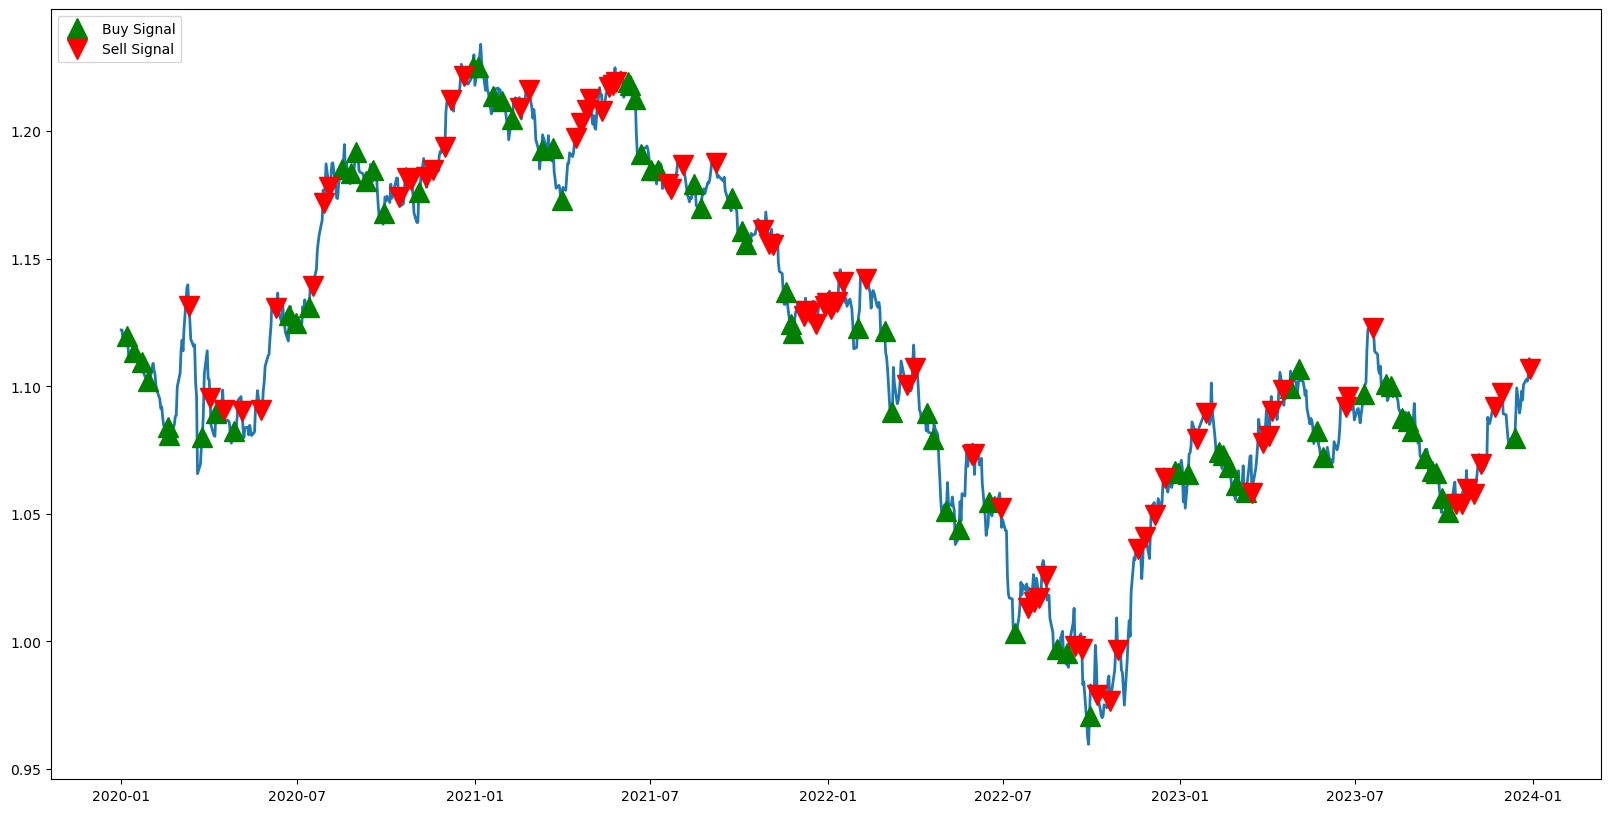

In [46]:
signal,buy_price,sell_price,position=strat_pkbmacd(df9)

df9['signal']=signal
df9['buy_price']=buy_price
df9['sell_price']=sell_price
df9['position']=position

plt.figure(figsize=(20,10))

plt.plot(df9['Close'], linewidth = 2)
plt.plot(df9.index, buy_price, marker = '^', color = 'green', markersize = 15, linewidth = 0, label = 'Buy Signal')
plt.plot(df9.index, sell_price, marker = 'v', color= 'r', markersize = 15, linewidth = 0, label = 'Sell Signal')
plt.legend(loc = 'upper left')
plt.show()

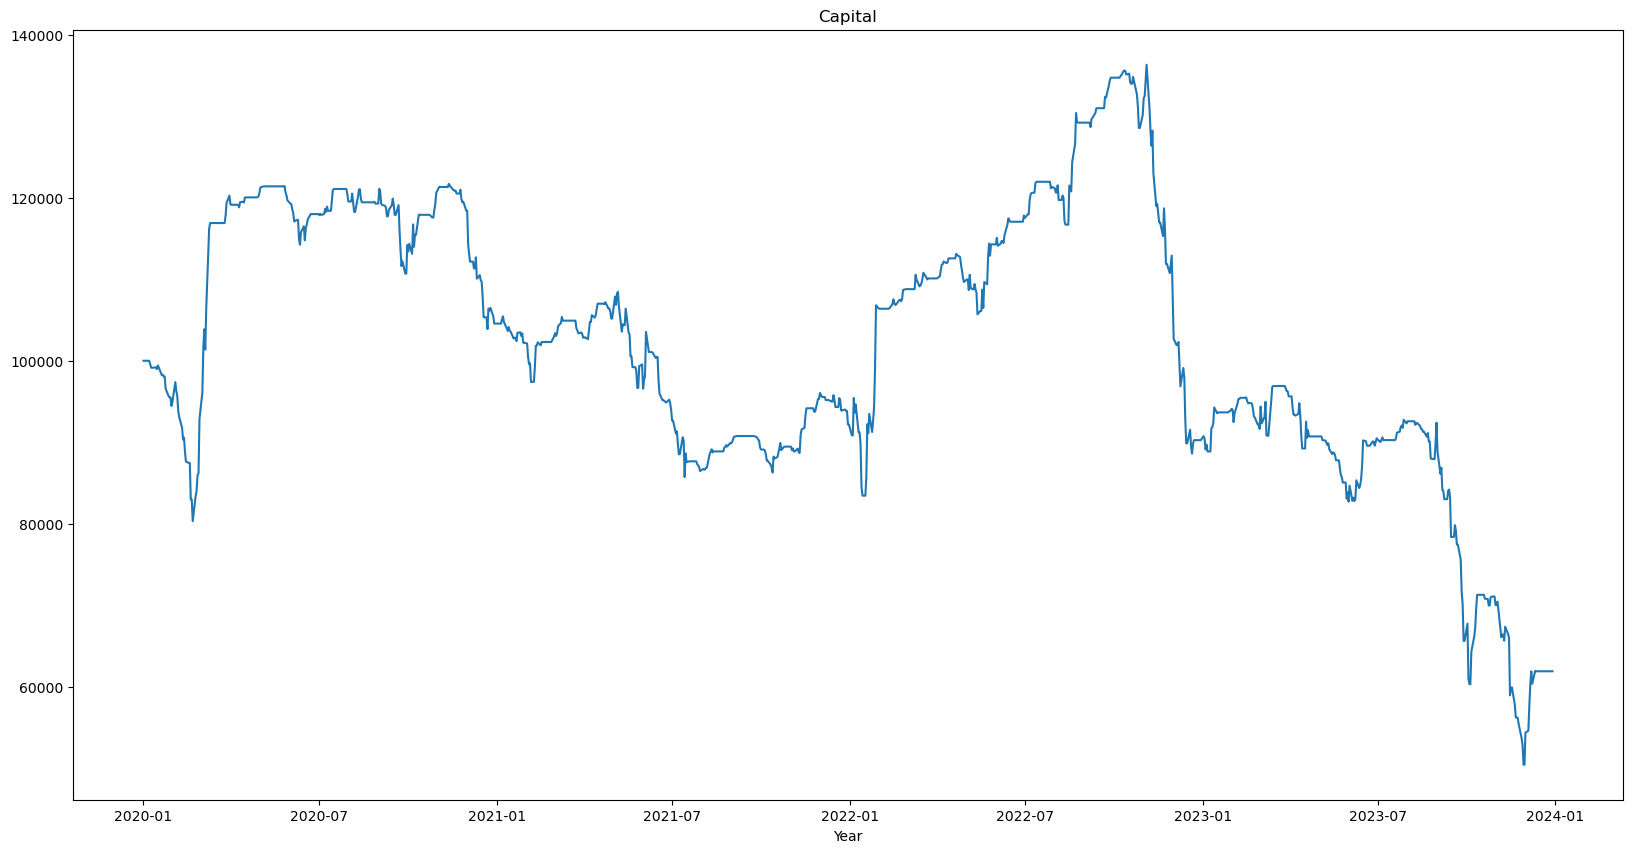

In [47]:
capital,pos_type = capx(df9,100000,100000)
df9['capital']=capital
df9['pos_type']=pos_type

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df9.index, df9['capital'], label='EUR USD')

ax.set_xlabel('Year')
plt.title("Capital")

plt.show()

# Bollinger Bands

In [48]:
df10=df.copy()

df10['ma'] = df10['Close'].rolling(window=20).mean()
df10['bbup'] = df10['ma'] + (2 * df10['Close'].rolling(window=20).std())
df10['bblow'] = df10['ma'] - (2 * df10['Close'].rolling(window=20).std())

In [49]:
def strat_bb(df):
    
    signal=[]
    signall = 0
    signals = 0
    buy_price=[]
    sell_price=[]
    position=[]
    
    for i in range(len(df)):
        if df['Close'][i] < df['bblow'][i]:
            if signall!=1:
                signal.append(1)
                signall=1
                signals=0
                buy_price.append(df['Close'][i])
                sell_price.append(np.nan)
                position.append("long")
            else:
                signal.append(0)
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                position.append(np.nan)
        elif df['Close'][i] > df['bbup'][i]:
            if signals!=-1:
                signal.append(-1)
                signals=-1
                signall=0
                buy_price.append(np.nan)
                sell_price.append(df['Close'][i])
                position.append("short")
            else:
                signal.append(0)
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                position.append(np.nan)
        else:
            signall=0
            signals=0
            signal.append(0)
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            position.append(np.nan)
            
    return signal,buy_price,sell_price,position

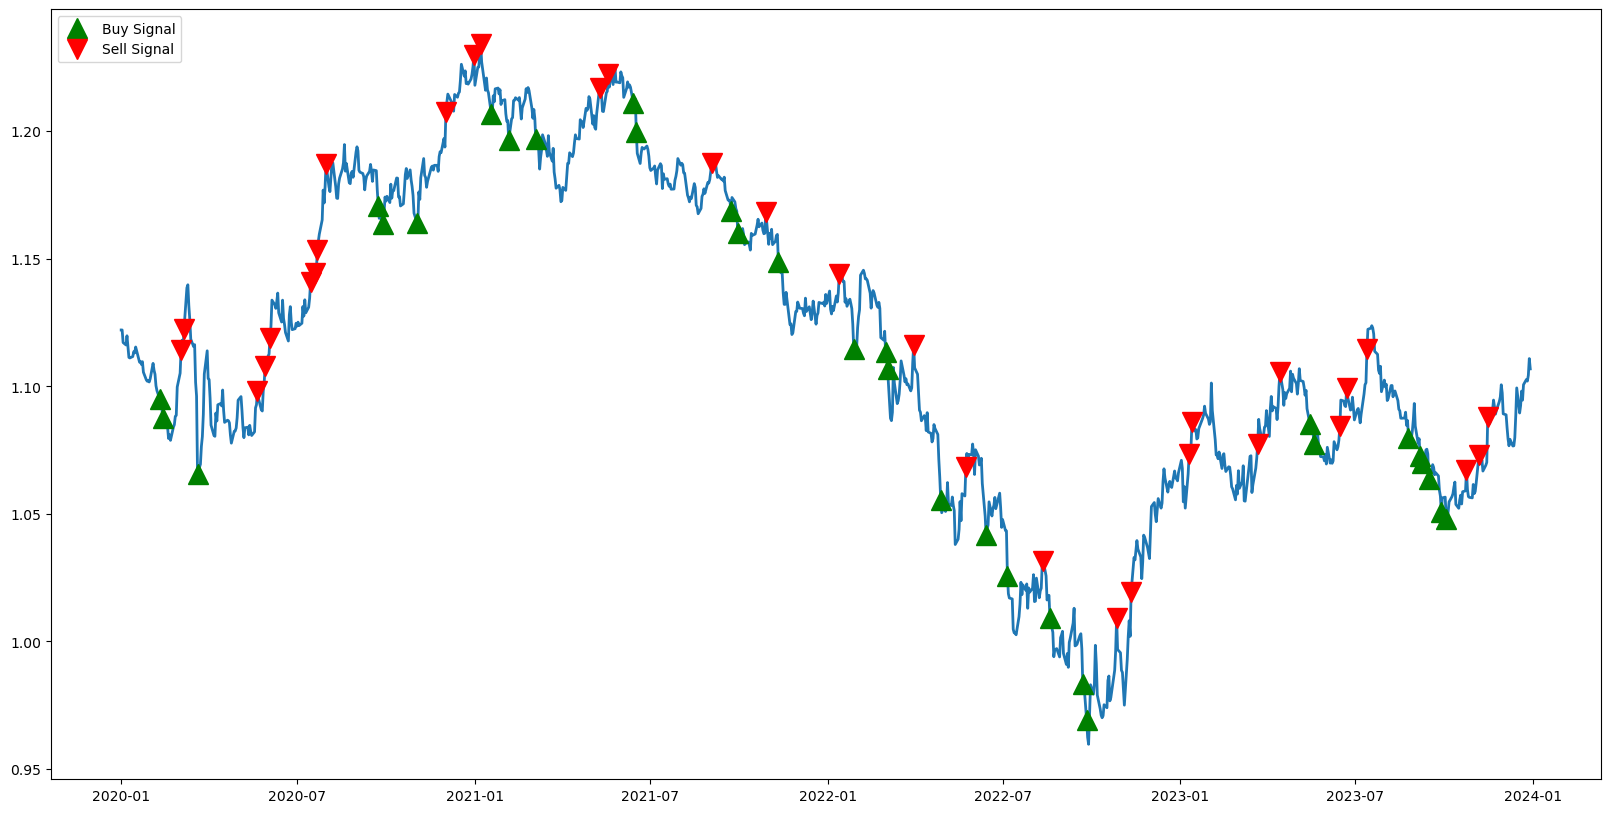

In [50]:
signal,buy_price,sell_price,position=strat_bb(df10)

df10['signal']=signal
df10['buy_price']=buy_price
df10['sell_price']=sell_price
df10['position']=position

plt.figure(figsize=(20,10))

plt.plot(df10['Close'], linewidth = 2)
plt.plot(df10.index, buy_price, marker = '^', color = 'green', markersize = 15, linewidth = 0, label = 'Buy Signal')
plt.plot(df10.index, sell_price, marker = 'v', color= 'r', markersize = 15, linewidth = 0, label = 'Sell Signal')
plt.legend(loc = 'upper left')
plt.show()

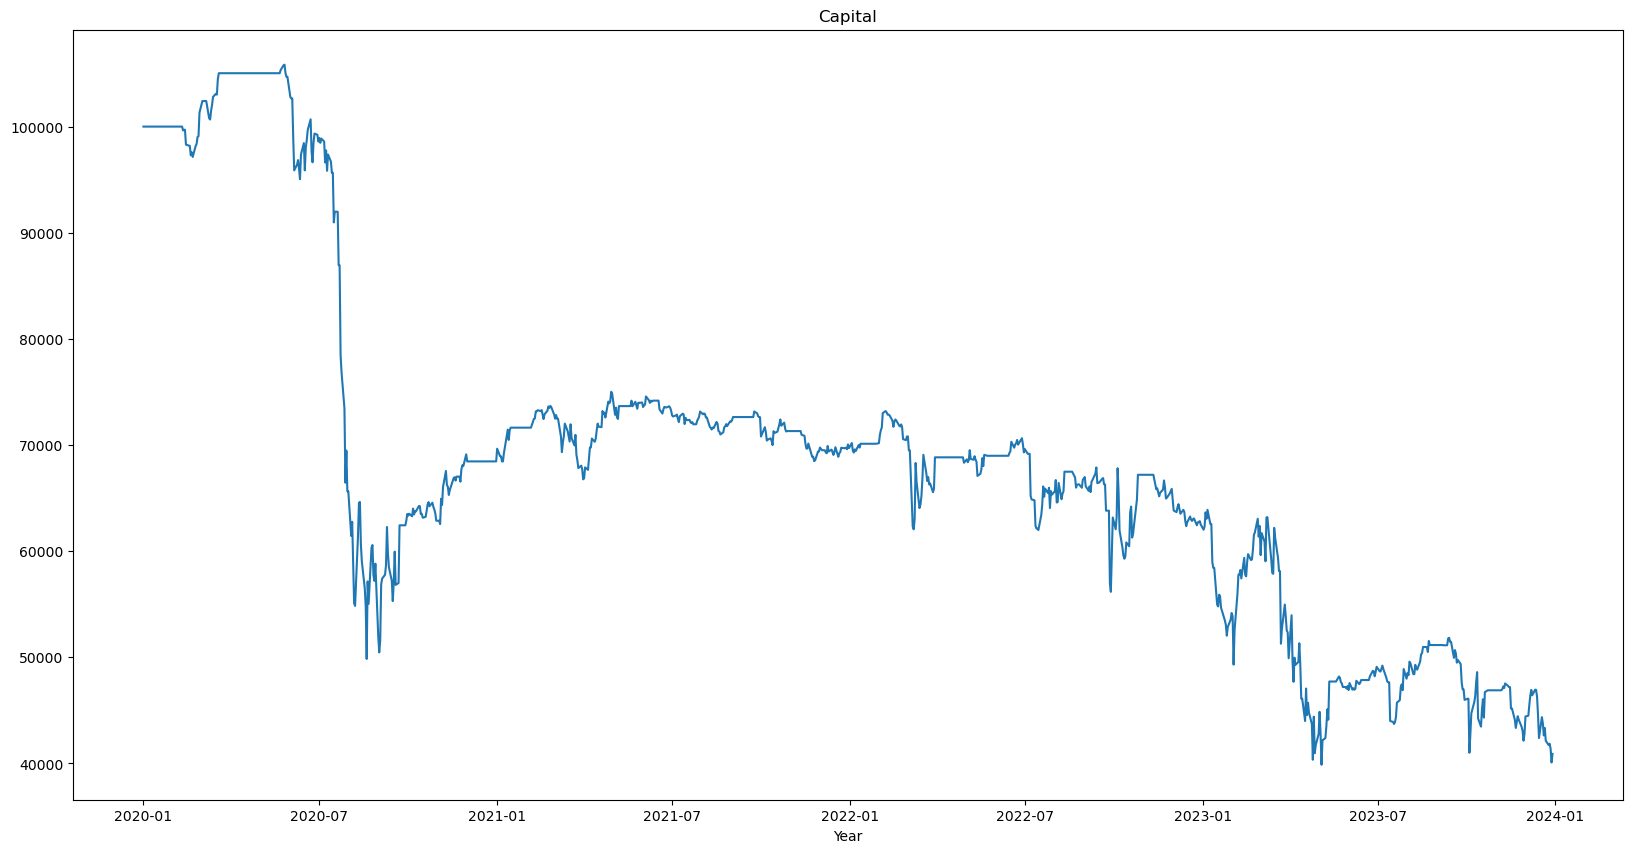

In [51]:
capital,pos_type = capx(df10,100000,100000)
df10['capital']=capital
df10['pos_type']=pos_type

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df10.index, df10['capital'], label='EUR USD')

ax.set_xlabel('Year')
plt.title("Capital")

plt.show()

# ICHIMOKU

In [52]:
def ichimoku(df, conversion_period, base_period, span_b_period):
    df['tenkan_sen'] = (df['High'].rolling(window=conversion_period).max() +
                        df['Low'].rolling(window=conversion_period).min()) / 2


    df['kijun_sen'] = (df['High'].rolling(window=base_period).max() +
                       df['Low'].rolling(window=base_period).min()) / 2

    df['senkou_span_a'] = ((df['tenkan_sen'] + df['kijun_sen']) / 2).shift(base_period)

    df['senkou_span_b'] = ((df['High'].rolling(window=span_b_period).max() +
                            df['Low'].rolling(window=span_b_period).min()) / 2).shift(base_period)
    
    return df

df11=df.copy()
df11=ichimoku(df11,9,26,52)

In [53]:
def strat_ichimoku(df):
    
    signal=[]
    signall = 0
    signals = 0
    buy_price=[]
    sell_price=[]
    position=[]
    
    for i in range(len(df)):
        if df['Close'][i] > df['senkou_span_a'][i] or df['Close'][i] > df['senkou_span_b'][i]:
            if signall!=1:
                signal.append(1)
                signall=1
                signals=0
                buy_price.append(df['Close'][i])
                sell_price.append(np.nan)
                position.append("long")
            else:
                signal.append(0)
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                position.append(np.nan)
        elif df['Close'][i] < df['senkou_span_a'][i] or df['Close'][i] < df['senkou_span_b'][i]:
            if signals!=-1:
                signal.append(-1)
                signals=-1
                signall=0
                buy_price.append(np.nan)
                sell_price.append(df['Close'][i])
                position.append("short")
            else:
                signal.append(0)
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                position.append(np.nan)
        else:
            signall=0
            signals=0
            signal.append(0)
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            position.append(np.nan)
            
    return signal,buy_price,sell_price,position

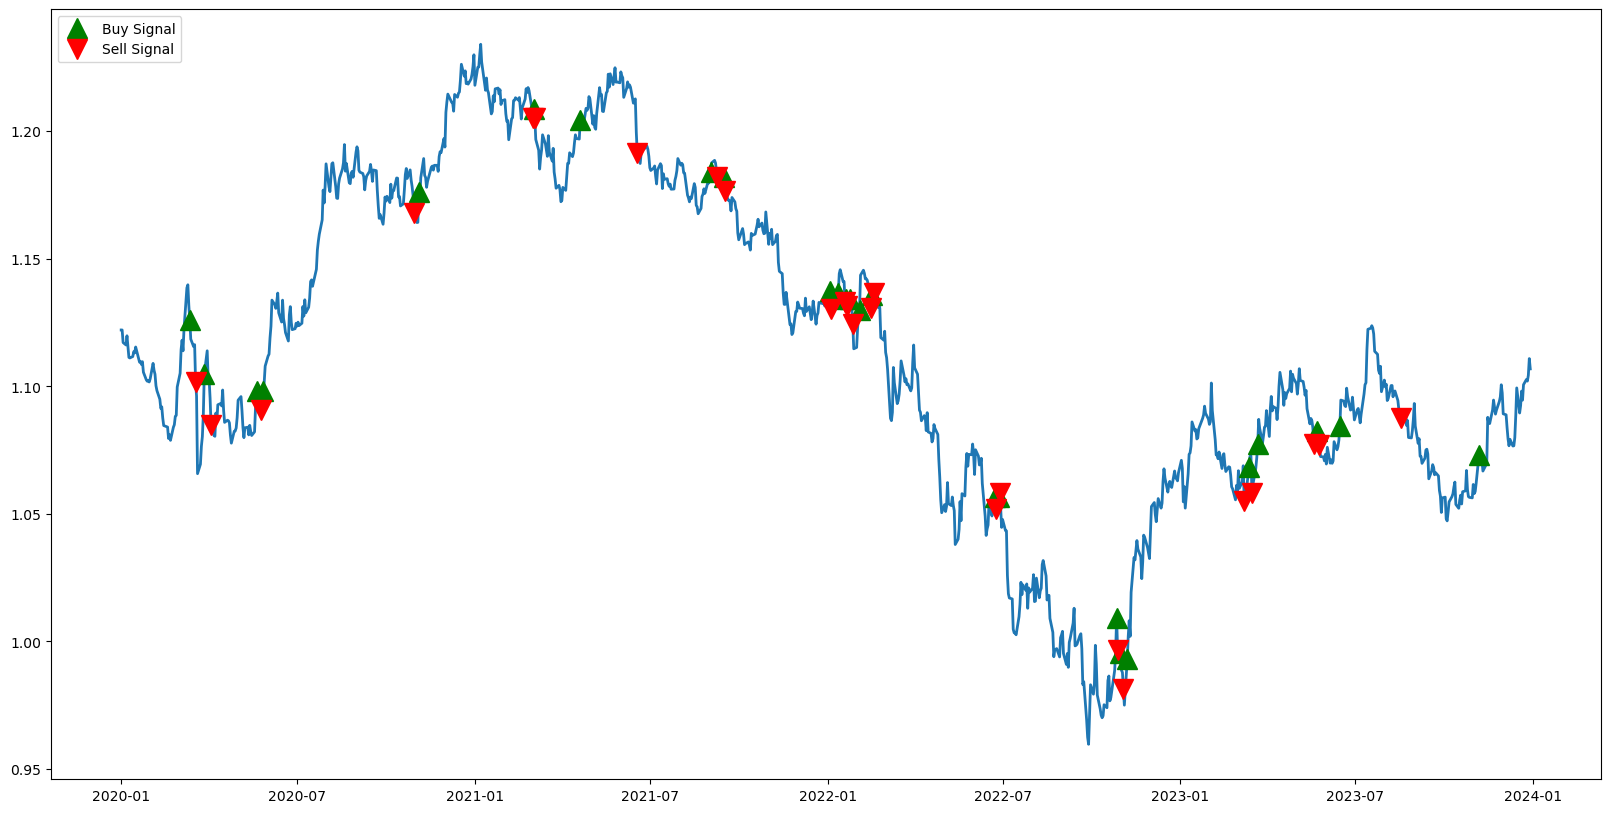

In [54]:
signal,buy_price,sell_price,position=strat_ichimoku(df11)

df11['signal']=signal
df11['buy_price']=buy_price
df11['sell_price']=sell_price
df11['position']=position

plt.figure(figsize=(20,10))

plt.plot(df11['Close'], linewidth = 2)
plt.plot(df11.index, buy_price, marker = '^', color = 'green', markersize = 15, linewidth = 0, label = 'Buy Signal')
plt.plot(df11.index, sell_price, marker = 'v', color= 'r', markersize = 15, linewidth = 0, label = 'Sell Signal')
plt.legend(loc = 'upper left')
plt.show()

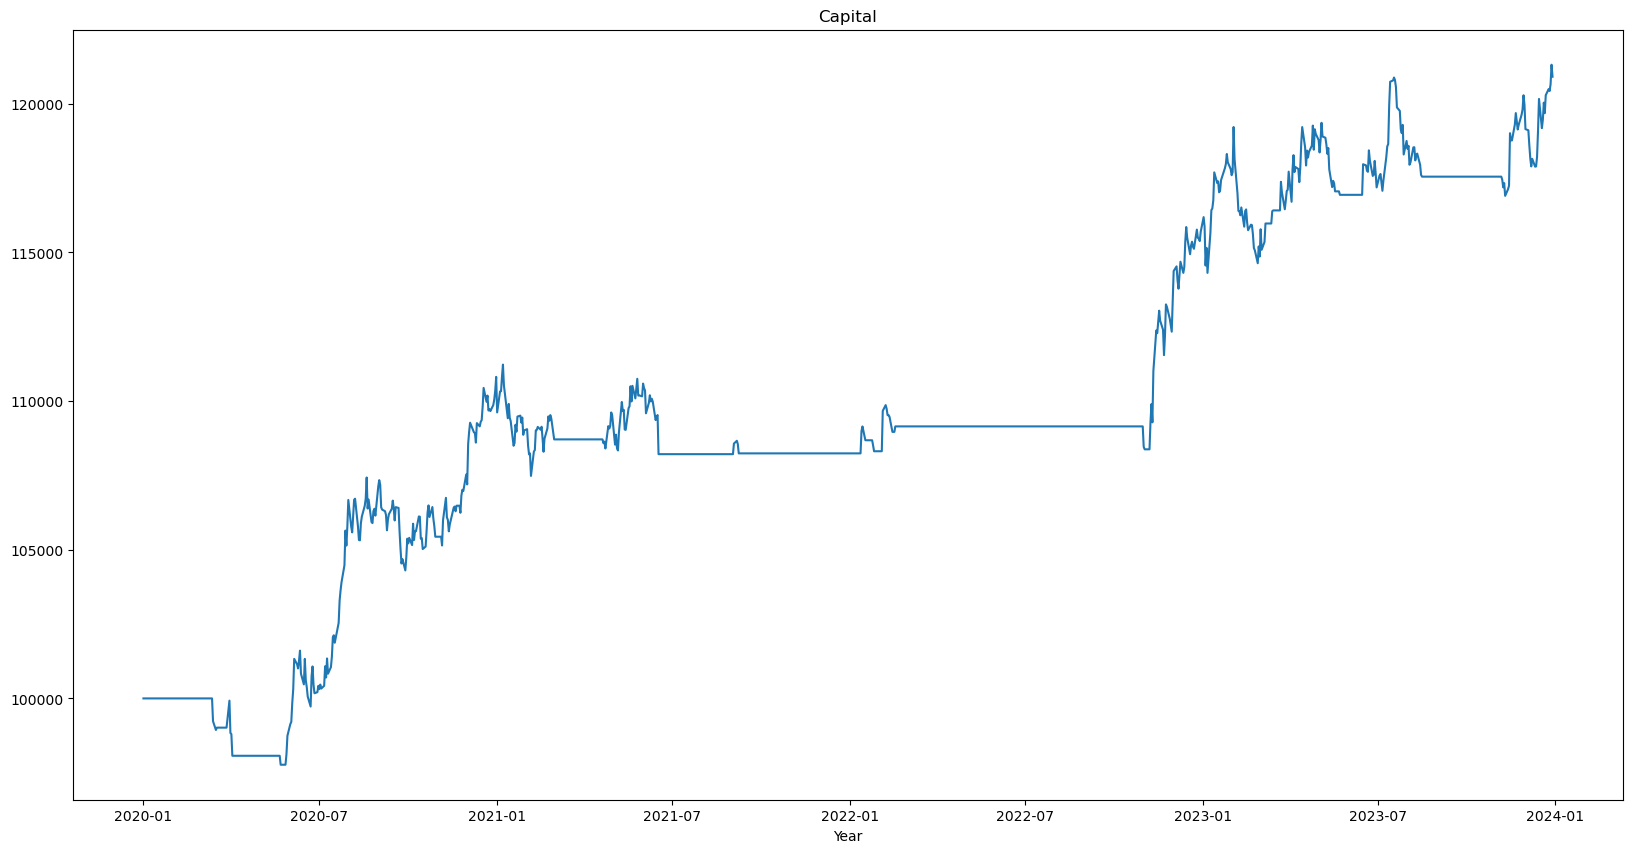

In [55]:
capital,pos_type = capx(df11,100000,100000)
df11['capital']=capital
df11['pos_type']=pos_type

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df11.index, df11['capital'], label='EUR USD')

ax.set_xlabel('Year')
plt.title("Capital")

plt.show()

# RSI of EWMA

In [56]:
df12=df.copy()

df12['ewma']=df12['Close'].ewm(span=50, adjust=False).mean()

rsi_indicator_ewma = RSIIndicator(df12['ewma'], window=14)
df12['rsi_ewma'] = rsi_indicator_ewma.rsi()

In [57]:
def strat_rsi(df):
    
    signal=[]
    signall = 0
    signals = 0
    buy_price=[]
    sell_price=[]
    position=[]
    
    for i in range(len(df)):
        if df['rsi_ewma'][i] < 30:
            if signall!=1:
                signal.append(1)
                signall=1
                signals=0
                buy_price.append(df['Close'][i])
                sell_price.append(np.nan)
                position.append("long")
            else:
                signal.append(0)
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                position.append(np.nan)
        elif df['rsi_ewma'][i] > 70:
            if signals!=-1:
                signal.append(-1)
                signals=-1
                signall=0
                buy_price.append(np.nan)
                sell_price.append(df['Close'][i])
                position.append("short")
            else:
                signal.append(0)
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                position.append(np.nan)
        else:
            signall=0
            signals=0
            signal.append(0)
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            position.append(np.nan)
            
    return signal,buy_price,sell_price,position

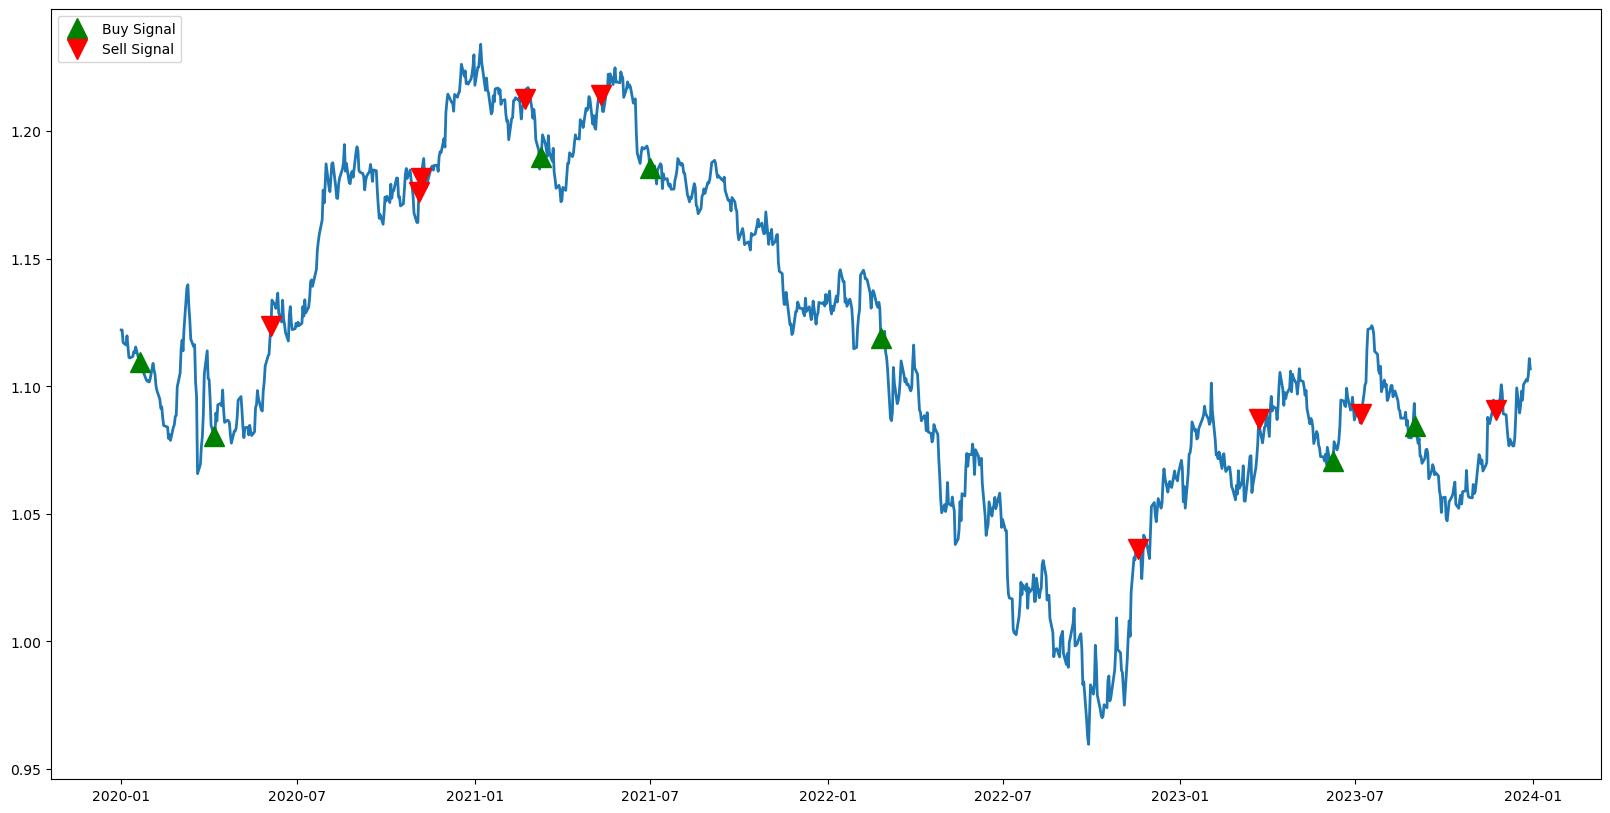

In [58]:
signal,buy_price,sell_price,position=strat_rsi(df12)

df12['signal']=signal
df12['buy_price']=buy_price
df12['sell_price']=sell_price
df12['position']=position

plt.figure(figsize=(20,10))

plt.plot(df12['Close'], linewidth = 2)
plt.plot(df12.index, buy_price, marker = '^', color = 'green', markersize = 15, linewidth = 0, label = 'Buy Signal')
plt.plot(df12.index, sell_price, marker = 'v', color= 'r', markersize = 15, linewidth = 0, label = 'Sell Signal')
plt.legend(loc = 'upper left')
plt.show()

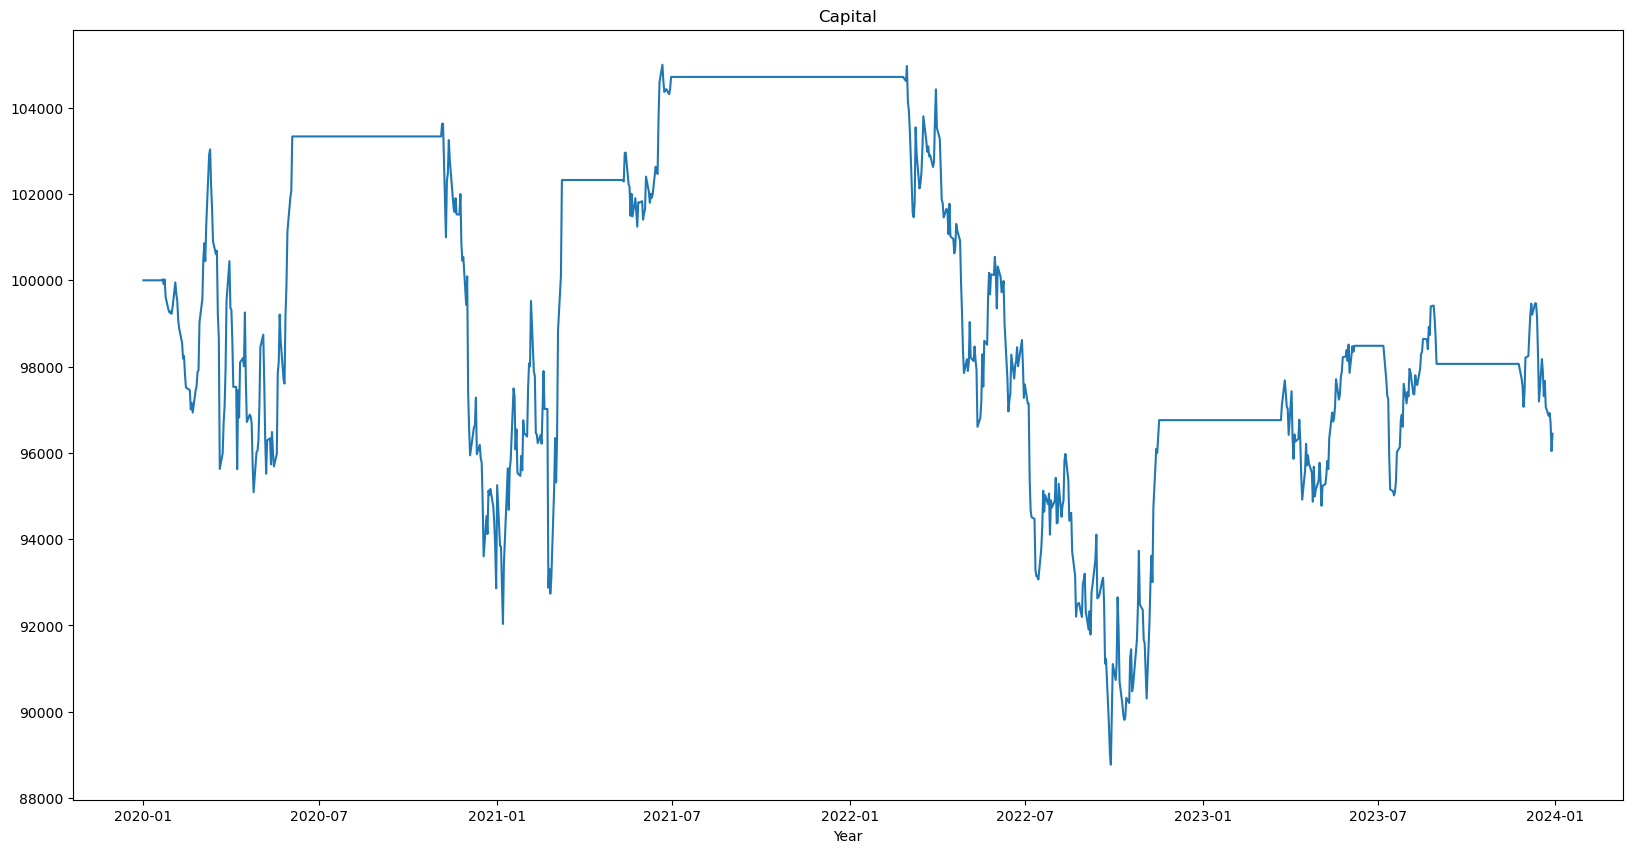

In [59]:
capital,pos_type = capx(df12,100000,100000)
df12['capital']=capital
df12['pos_type']=pos_type

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df12.index, df12['capital'], label='EUR USD')

ax.set_xlabel('Year')
plt.title("Capital")

plt.show()

# Super Trend

In [60]:
df13=df.copy()

def calculate_supertrend(df, atr_period, multiplier):
    high_low = df['High'] - df['Low']
    high_close = np.abs(df['High'] - df['Close'].shift())
    low_close = np.abs(df['Low'] - df['Close'].shift())
    true_range = high_low.combine(high_close, max).combine(low_close, max)
    atr = true_range.rolling(atr_period).mean()

    basic_upper_band = (df['High'] + df['Low']) / 2 + multiplier * atr
    basic_lower_band = (df['High'] + df['Low']) / 2 - multiplier * atr

    supertrend = pd.DataFrame(index=df.index)
    supertrend['upper_band'] = basic_upper_band
    supertrend['lower_band'] = basic_lower_band
    supertrend['supertrend'] = np.nan

    for i in range(1, len(df)):
        if df['Close'][i-1] <= supertrend['upper_band'][i-1]:
            supertrend['upper_band'][i] = min(basic_upper_band[i], supertrend['upper_band'][i-1])
        else:
            supertrend['upper_band'][i] = basic_upper_band[i]

        if df['Close'][i-1] >= supertrend['lower_band'][i-1]:
            supertrend['lower_band'][i] = max(basic_lower_band[i], supertrend['lower_band'][i-1])
        else:
            supertrend['lower_band'][i] = basic_lower_band[i]

        if df['Close'][i] > supertrend['upper_band'][i-1]:
            supertrend['supertrend'][i] = supertrend['lower_band'][i]
        elif df['Close'][i] < supertrend['lower_band'][i-1]:
            supertrend['supertrend'][i] = supertrend['upper_band'][i]
        else:
            supertrend['supertrend'][i] = supertrend['supertrend'][i-1]

    return supertrend['supertrend']

In [61]:
supertrend=calculate_supertrend(df13,10,3)
df13['supertrend']=supertrend

In [62]:
def strat_supertrend(df):
    
    signal=[]
    signall = 0
    signals = 0
    buy_price=[]
    sell_price=[]
    position=[]
    
    for i in range(len(df)):
        if df['Close'][i] > df['supertrend'][i]:
            if signall!=1:
                signal.append(1)
                signall=1
                signals=0
                buy_price.append(df['Close'][i])
                sell_price.append(np.nan)
                position.append("long")
            else:
                signal.append(0)
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                position.append(np.nan)
        elif df['Close'][i] < df['supertrend'][i]:
            if signals!=-1:
                signal.append(-1)
                signals=-1
                signall=0
                buy_price.append(np.nan)
                sell_price.append(df['Close'][i])
                position.append("short")
            else:
                signal.append(0)
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                position.append(np.nan)
        else:
            signall=0
            signals=0
            signal.append(0)
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            position.append(np.nan)
            
    return signal,buy_price,sell_price,position

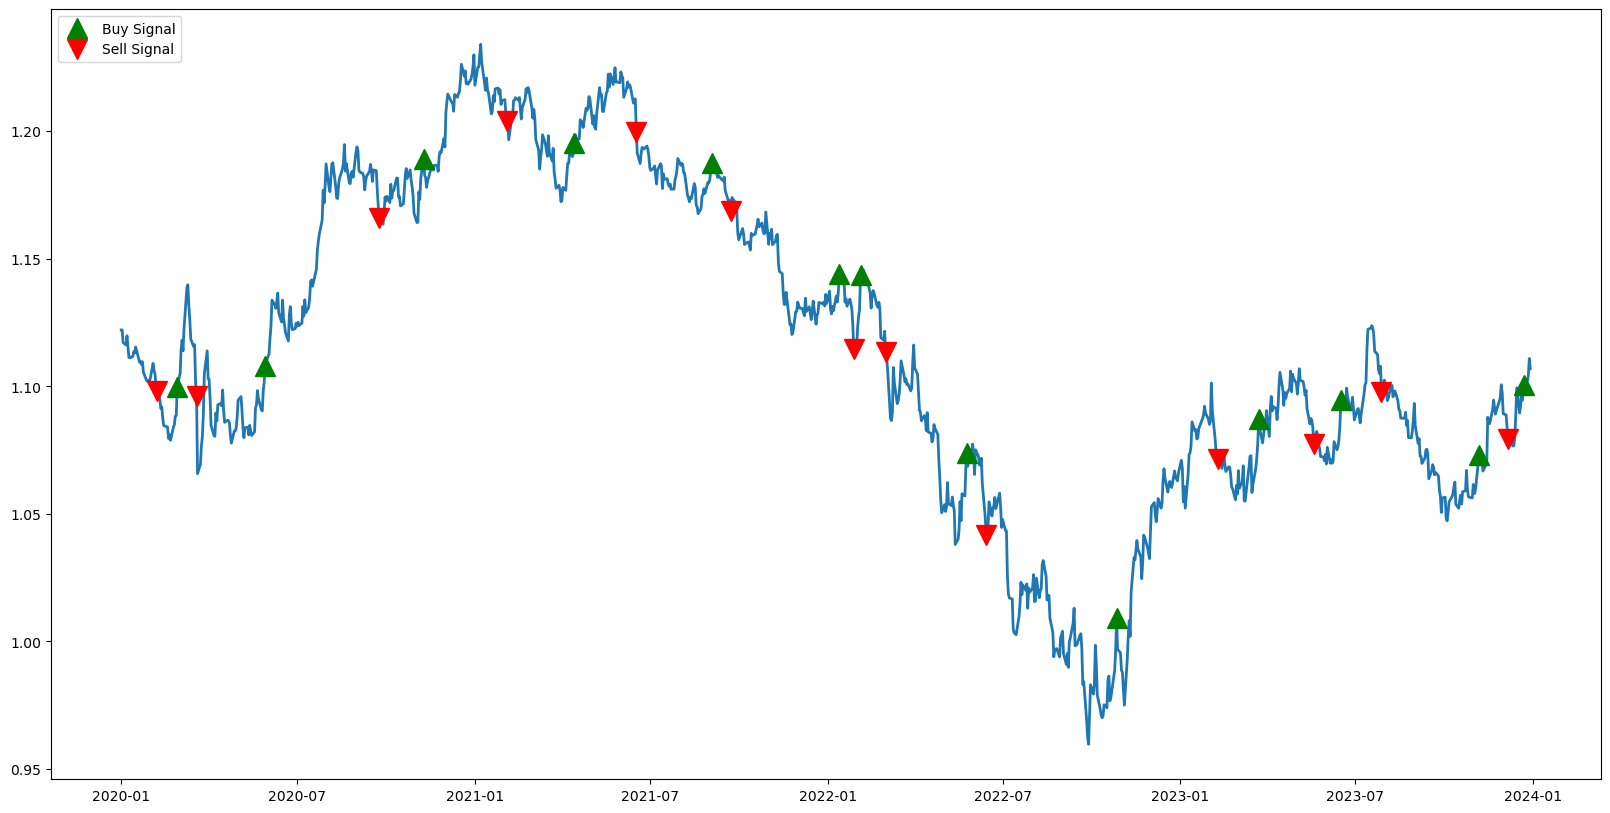

In [63]:
signal,buy_price,sell_price,position=strat_supertrend(df13)

df13['signal']=signal
df13['buy_price']=buy_price
df13['sell_price']=sell_price
df13['position']=position

plt.figure(figsize=(20,10))

plt.plot(df13['Close'], linewidth = 2)
plt.plot(df13.index, buy_price, marker = '^', color = 'green', markersize = 15, linewidth = 0, label = 'Buy Signal')
plt.plot(df13.index, sell_price, marker = 'v', color= 'r', markersize = 15, linewidth = 0, label = 'Sell Signal')
plt.legend(loc = 'upper left')
plt.show()

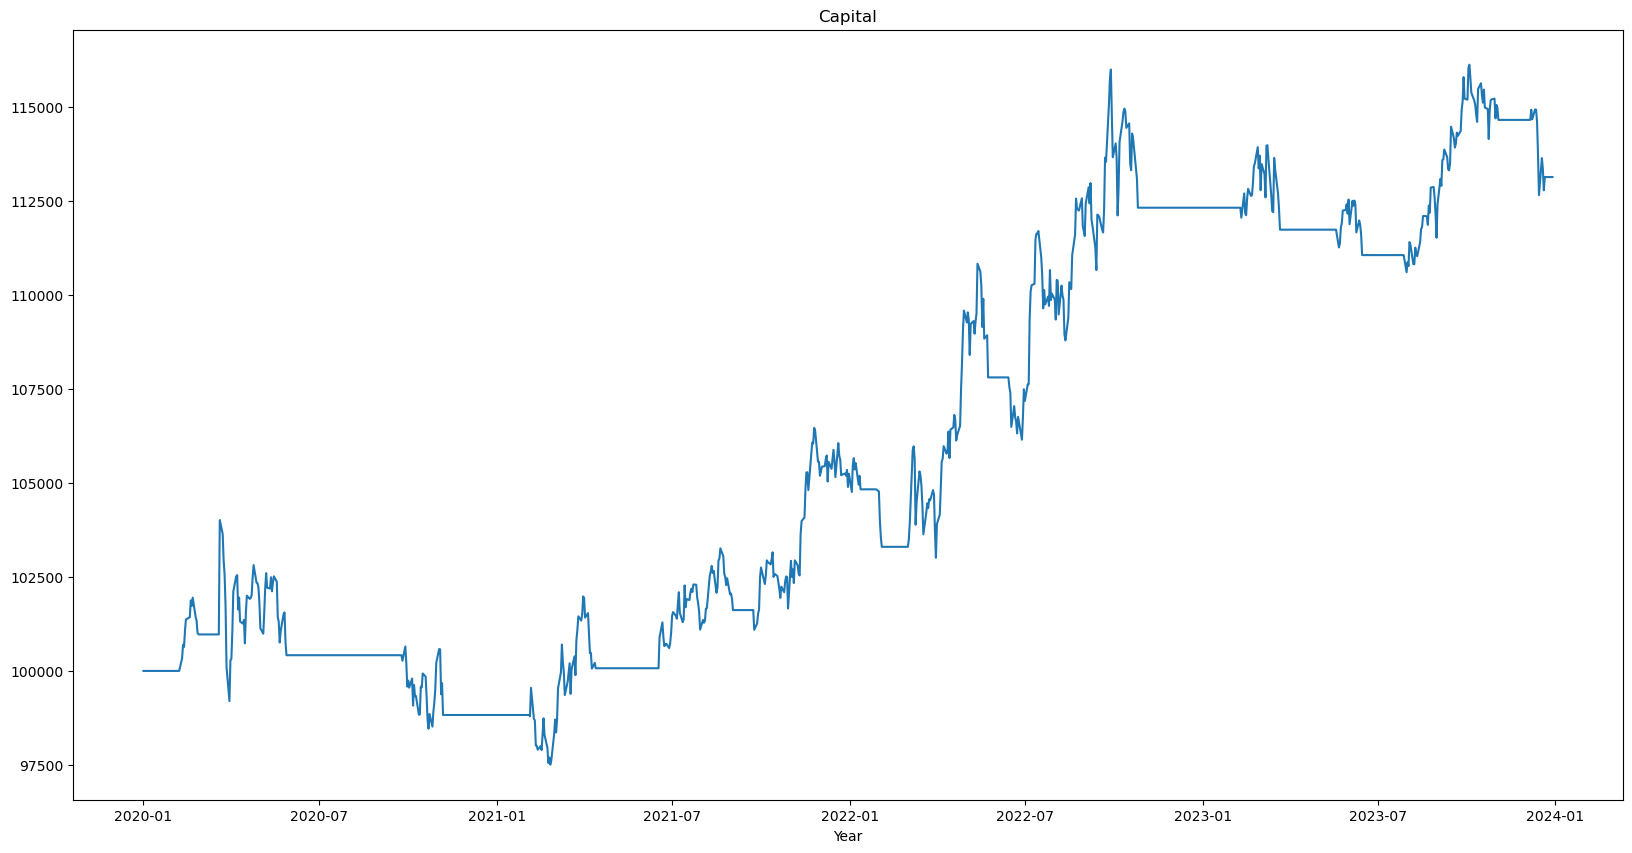

In [64]:
capital,pos_type = capx(df13,100000,100000)
df13['capital']=capital
df13['pos_type']=pos_type

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df13.index, df13['capital'], label='EUR USD')

ax.set_xlabel('Year')
plt.title("Capital")

plt.show()

# Average Directional Index

In [65]:
from ta.trend import ADXIndicator

df14=df.copy()

adx_ind = ADXIndicator(df.High,df.Low,df.Close,window=14,fillna=False)
df14['adx']=adx_ind.adx()
df14['positive']=adx_ind.adx_pos()
df14['negative']=adx_ind.adx_neg()

In [66]:
def strat_adx(df):
    
    signal=[]
    signall = 0
    signals = 0
    buy_price=[]
    sell_price=[]
    position=[]
    
    for i in range(len(df)):
        if df['adx'][i]>20:
            if df['positive'][i] > df['negative'][i]:
                if signall!=1:
                    signal.append(1)
                    signall=1
                    signals=0
                    buy_price.append(df['Close'][i])
                    sell_price.append(np.nan)
                    position.append("long")
                else:
                    signal.append(0)
                    buy_price.append(np.nan)
                    sell_price.append(np.nan)
                    position.append(np.nan)
            elif df['positive'][i] < df['negative'][i]:
                if signals!=-1:
                    signal.append(-1)
                    signals=-1
                    signall=0
                    buy_price.append(np.nan)
                    sell_price.append(df['Close'][i])
                    position.append("short")
                else:
                    signal.append(0)
                    buy_price.append(np.nan)
                    sell_price.append(np.nan)
                    position.append(np.nan)
            else:
                signall=0
                signals=0
                signal.append(0)
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                position.append(np.nan)
        else:
            signall=0
            signals=0
            signal.append(0)
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            position.append(np.nan)
            
    return signal,buy_price,sell_price,position

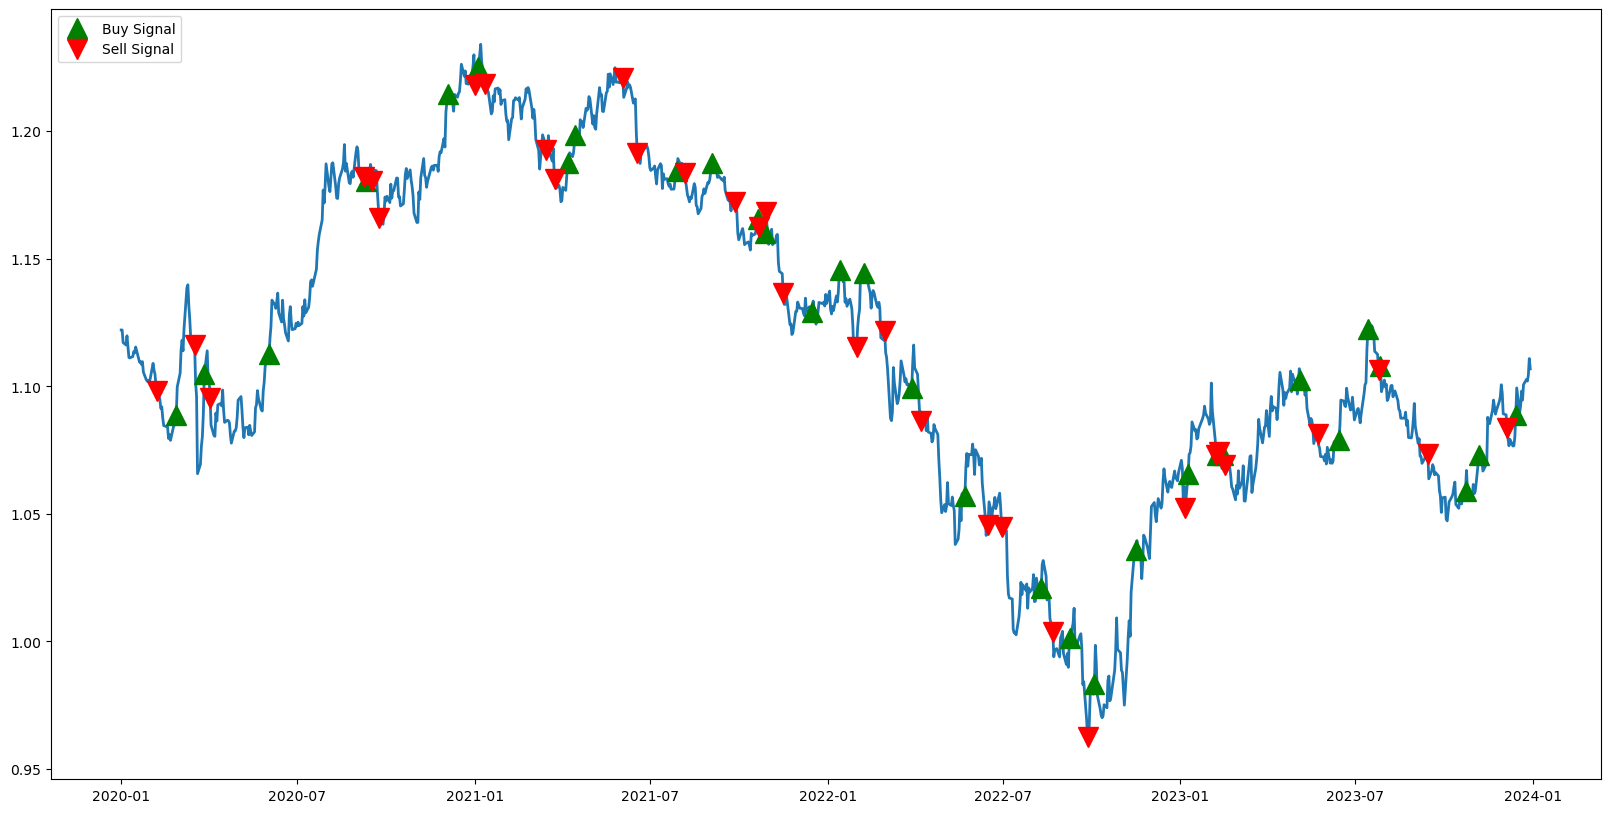

In [67]:
signal,buy_price,sell_price,position=strat_adx(df14)

df14['signal']=signal
df14['buy_price']=buy_price
df14['sell_price']=sell_price
df14['position']=position

plt.figure(figsize=(20,10))

plt.plot(df14['Close'], linewidth = 2)
plt.plot(df14.index, buy_price, marker = '^', color = 'green', markersize = 15, linewidth = 0, label = 'Buy Signal')
plt.plot(df14.index, sell_price, marker = 'v', color= 'r', markersize = 15, linewidth = 0, label = 'Sell Signal')
plt.legend(loc = 'upper left')
plt.show()

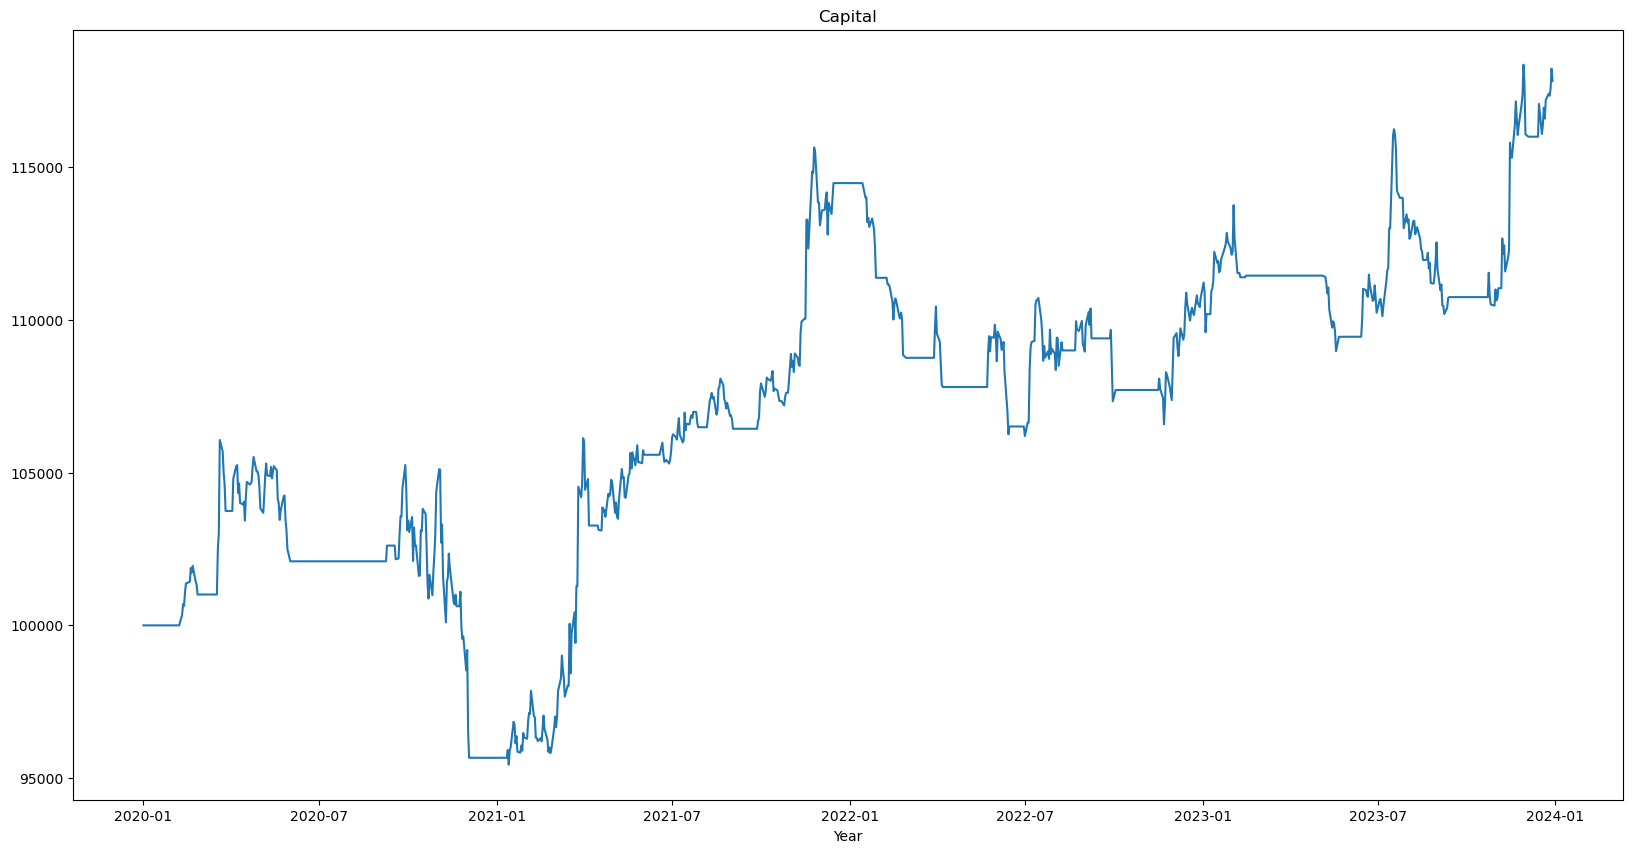

In [68]:
capital,pos_type = capx(df14,100000,100000)
df14['capital']=capital
df14['pos_type']=pos_type

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df14.index, df14['capital'], label='EUR USD')

ax.set_xlabel('Year')
plt.title("Capital")

plt.show()

# Aroon

In [69]:
from ta.trend import AroonIndicator

df15=df.copy()

aroon_ind=AroonIndicator(df15.Close,df15.Low,window=25,fillna=False)
df15['aroon']=aroon_ind.aroon_indicator()

In [70]:
def strat_aroon(df):
    
    signal=[]
    signall = 0
    signals = 0
    buy_price=[]
    sell_price=[]
    position=[]
    
    for i in range(len(df)):
        if df['aroon'][i] > 0:
            if signall!=1:
                signal.append(1)
                signall=1
                signals=0
                buy_price.append(df['Close'][i])
                sell_price.append(np.nan)
                position.append("long")
            else:
                signal.append(0)
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                position.append(np.nan)
        elif df['aroon'][i] < 0:
            if signals!=-1:
                signal.append(-1)
                signals=-1
                signall=0
                buy_price.append(np.nan)
                sell_price.append(df['Close'][i])
                position.append("short")
            else:
                signal.append(0)
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                position.append(np.nan)
        else:
            signall=0
            signals=0
            signal.append(0)
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            position.append(np.nan)
            
    return signal,buy_price,sell_price,position

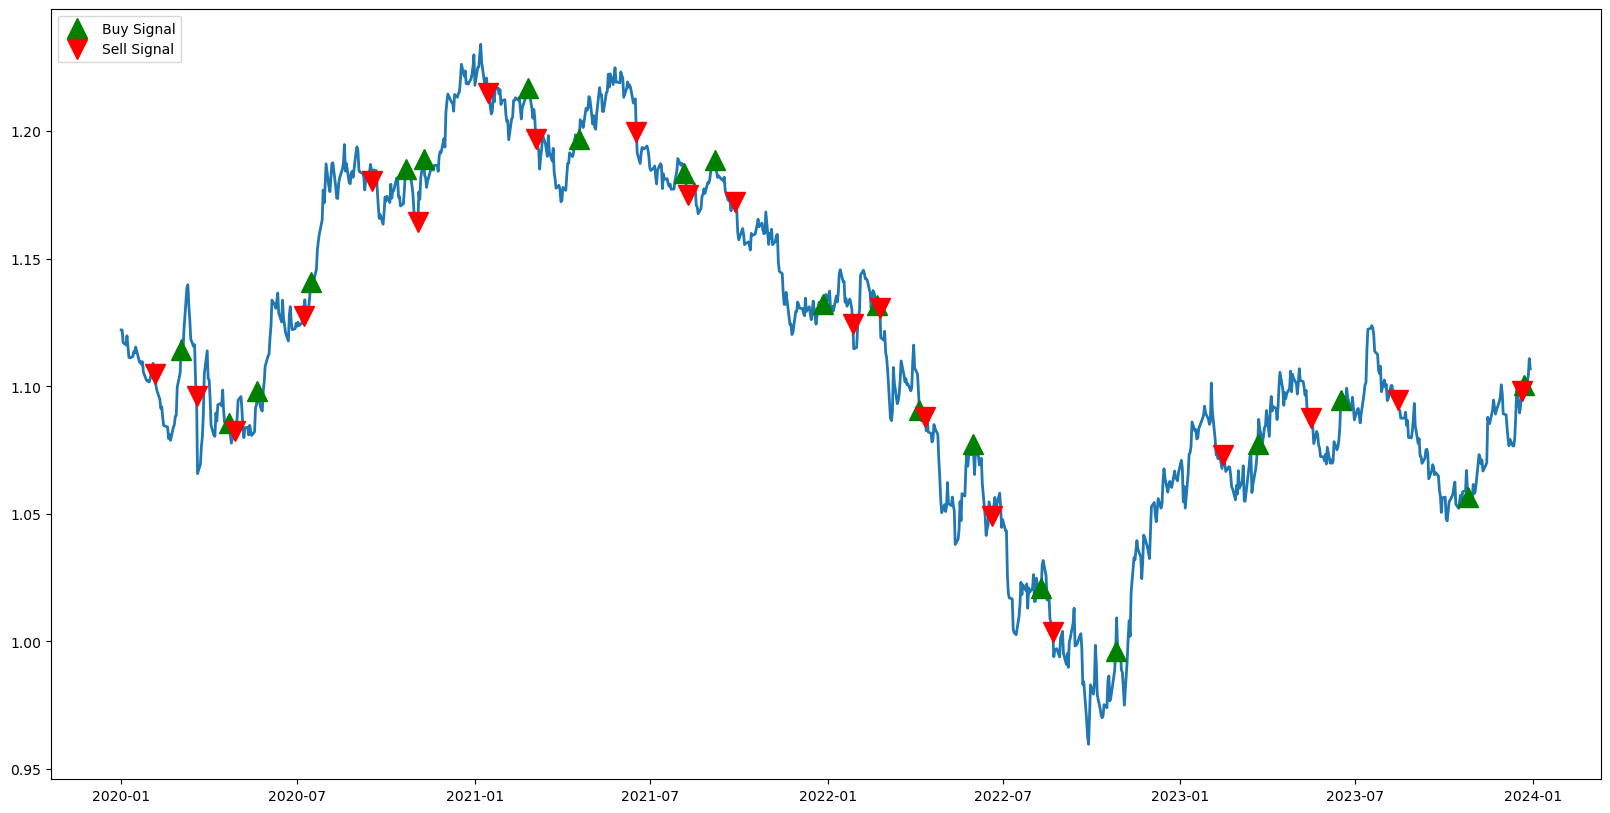

In [71]:
signal,buy_price,sell_price,position=strat_aroon(df15)

df15['signal']=signal
df15['buy_price']=buy_price
df15['sell_price']=sell_price
df15['position']=position

plt.figure(figsize=(20,10))

plt.plot(df15['Close'], linewidth = 2)
plt.plot(df15.index, buy_price, marker = '^', color = 'green', markersize = 15, linewidth = 0, label = 'Buy Signal')
plt.plot(df15.index, sell_price, marker = 'v', color= 'r', markersize = 15, linewidth = 0, label = 'Sell Signal')
plt.legend(loc = 'upper left')
plt.show()

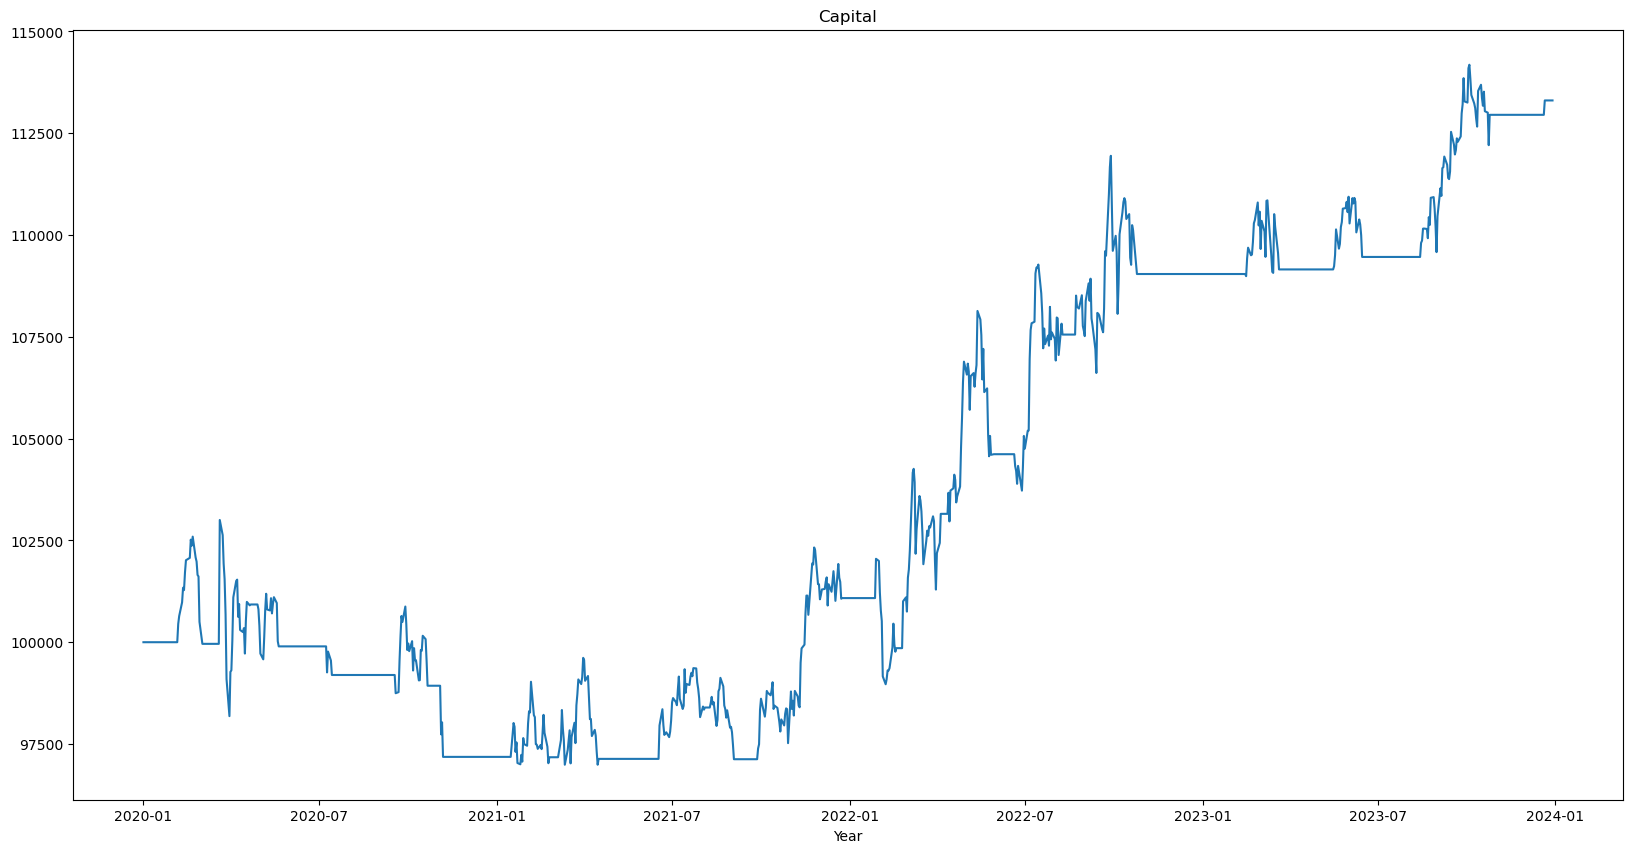

In [72]:
capital,pos_type = capx(df15,100000,100000)
df15['capital']=capital
df15['pos_type']=pos_type

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df15.index, df15['capital'], label='EUR USD')

ax.set_xlabel('Year')
plt.title("Capital")

plt.show()

# William %R

In [73]:
from ta.momentum import WilliamsRIndicator

df16=df.copy()

will_r=WilliamsRIndicator(df.High,df.Low,df.Close,lbp=14,fillna=False)
df16['williamsr']=will_r.williams_r()

In [74]:
def strat_williamsr(df):
    
    signal=[]
    signall = 0
    signals = 0
    buy_price=[]
    sell_price=[]
    position=[]
    
    for i in range(len(df)):
        if df['williamsr'][i] > -20:
            if signall!=1:
                signal.append(1)
                signall=1
                signals=0
                buy_price.append(df['Close'][i])
                sell_price.append(np.nan)
                position.append("long")
            else:
                signal.append(0)
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                position.append(np.nan)
        elif df['williamsr'][i] < -80:
            if signals!=-1:
                signal.append(-1)
                signals=-1
                signall=0
                buy_price.append(np.nan)
                sell_price.append(df['Close'][i])
                position.append("short")
            else:
                signal.append(0)
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                position.append(np.nan)
        else:
            signall=0
            signals=0
            signal.append(0)
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            position.append(np.nan)
            
    return signal,buy_price,sell_price,position

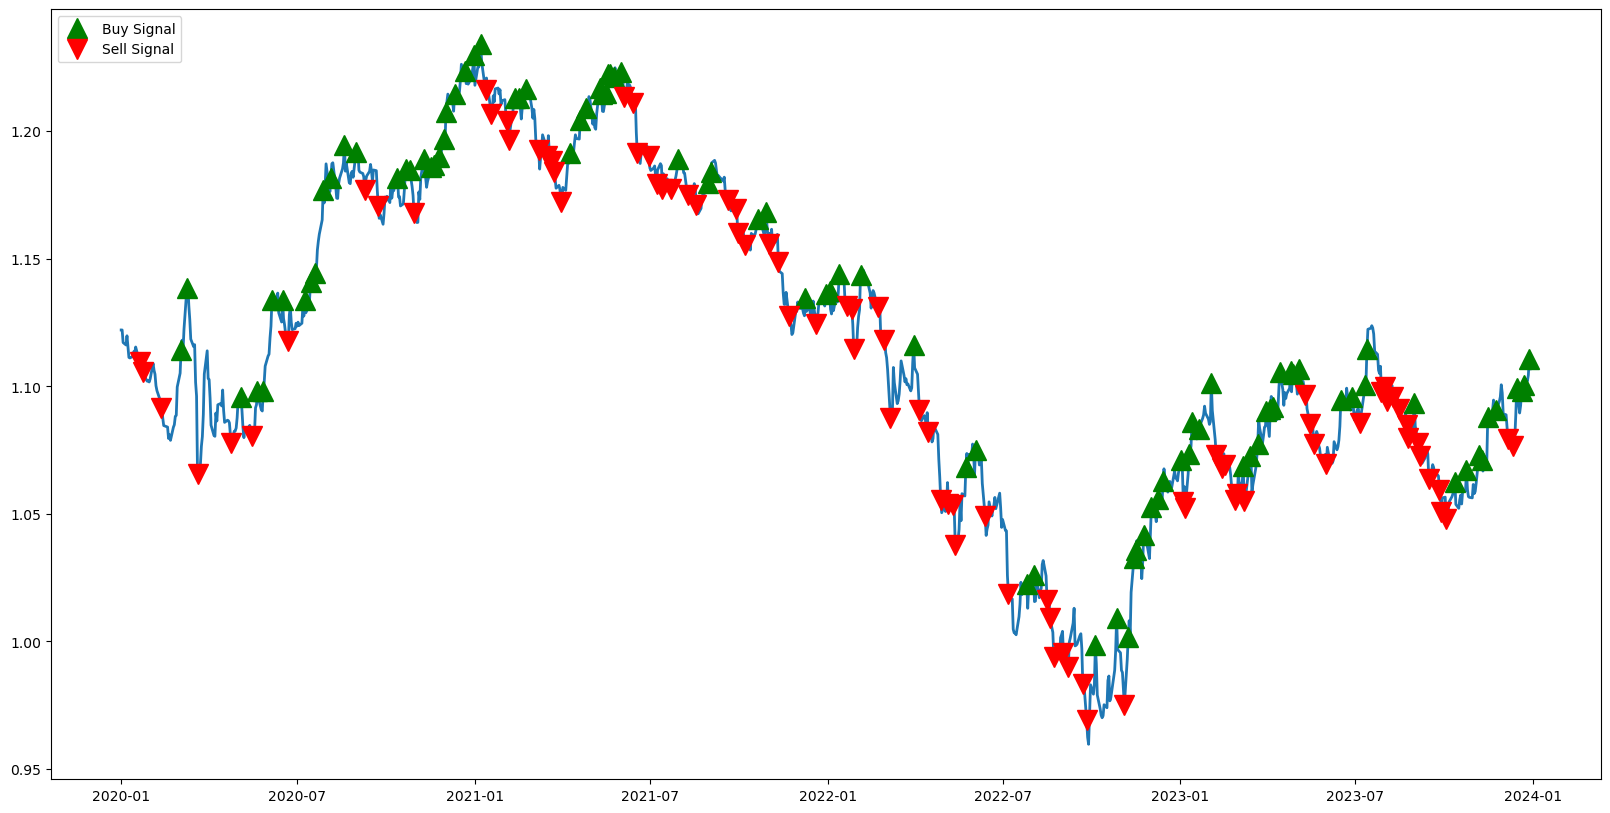

In [75]:
signal,buy_price,sell_price,position=strat_williamsr(df16)

df16['signal']=signal
df16['buy_price']=buy_price
df16['sell_price']=sell_price
df16['position']=position

plt.figure(figsize=(20,10))

plt.plot(df16['Close'], linewidth = 2)
plt.plot(df16.index, buy_price, marker = '^', color = 'green', markersize = 15, linewidth = 0, label = 'Buy Signal')
plt.plot(df15.index, sell_price, marker = 'v', color= 'r', markersize = 15, linewidth = 0, label = 'Sell Signal')
plt.legend(loc = 'upper left')
plt.show()

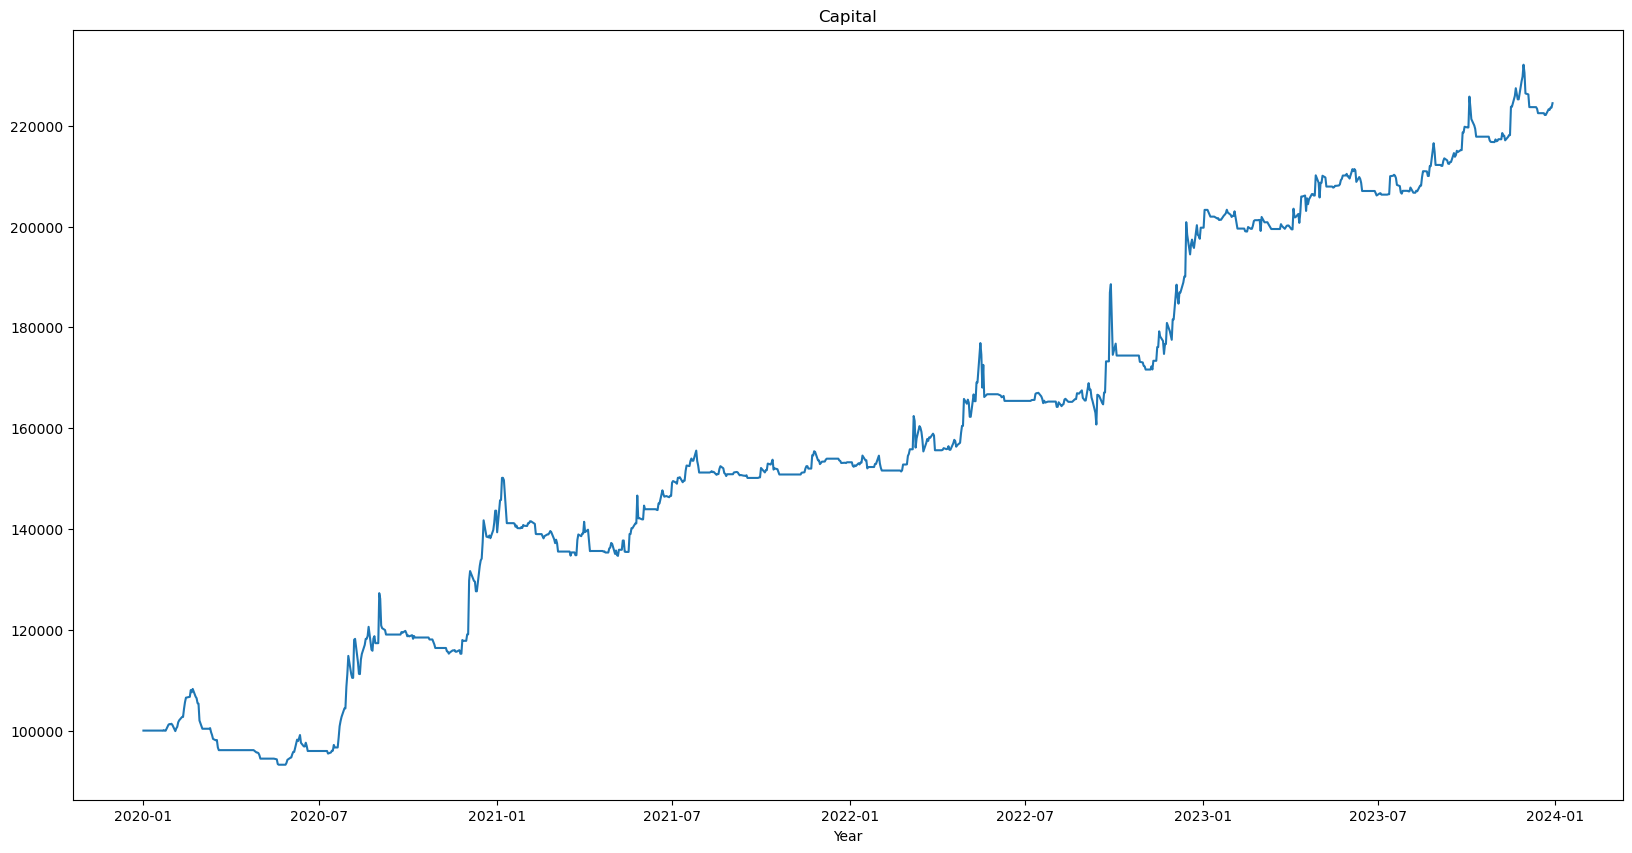

In [76]:
capital,pos_type = capx(df16,100000,100000)
df16['capital']=capital
df16['pos_type']=pos_type

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df16.index, df16['capital'], label='EUR USD')

ax.set_xlabel('Year')
plt.title("Capital")

plt.show()

# Buy/Sell signals of all 16 filters

In [77]:
dfz = df.copy()
dfz=dfz.drop(columns=['Open','High','Low','Volume','Adj Close'])

In [78]:
lists = {}

for i in range(1,33):                                 # creating 32 lists
    lists['{}{}'.format("f", i)] = []   
for i in range(1,33):
    exec('{} = []'.format('f' + str(i)))

for i in range(len(df)):
    if df1['signal'][i]==1:
        f1.append(1)
        f17.append(0)
    elif df1['signal'][i]==-1:
        f1.append(0)
        f17.append(1)
    else:
        f1.append(0)
        f17.append(0)

for i in range(len(df)):
    if df2['signal'][i]==1:
        f2.append(1)
        f18.append(0)
    elif df2['signal'][i]==-1:
        f2.append(0)
        f18.append(1)
    else:
        f2.append(0)
        f18.append(0)
        
for i in range(len(df)):
    if df3['signal'][i]==1:
        f3.append(1)
        f19.append(0)
    elif df3['signal'][i]==-1:
        f3.append(0)
        f19.append(1)
    else:
        f3.append(0)
        f19.append(0)
        
for i in range(len(df)):
    if df4['signal'][i]==1:
        f4.append(1)
        f20.append(0)
    elif df4['signal'][i]==-1:
        f4.append(0)
        f20.append(1)
    else:
        f4.append(0)
        f20.append(0)
        
for i in range(len(df)):
    if df5['signal'][i]==1:
        f5.append(1)
        f21.append(0)
    elif df5['signal'][i]==-1:
        f5.append(0)
        f21.append(1)
    else:
        f5.append(0)
        f21.append(0)
    
for i in range(len(df)):
    if df6['signal'][i]==1:
        f6.append(1)
        f22.append(0)
    elif df6['signal'][i]==-1:
        f6.append(0)
        f22.append(1)
    else:
        f6.append(0)
        f22.append(0)
        
for i in range(len(df)):
    if df7['signal'][i]==1:
        f7.append(1)
        f23.append(0)
    elif df7['signal'][i]==-1:
        f7.append(0)
        f23.append(1)
    else:
        f7.append(0)
        f23.append(0)
        
for i in range(len(df)):
    if df8['signal'][i]==1:
        f8.append(1)
        f24.append(0)
    elif df8['signal'][i]==-1:
        f8.append(0)
        f24.append(1)
    else:
        f8.append(0)
        f24.append(0)
        
for i in range(len(df)):
    if df9['signal'][i]==1:
        f9.append(1)
        f25.append(0)
    elif df9['signal'][i]==-1:
        f9.append(0)
        f25.append(1)
    else:
        f9.append(0)
        f25.append(0)
        
for i in range(len(df)):
    if df10['signal'][i]==1:
        f10.append(1)
        f26.append(0)
    elif df10['signal'][i]==-1:
        f10.append(0)
        f26.append(1)
    else:
        f10.append(0)
        f26.append(0)
        
for i in range(len(df)):
    if df11['signal'][i]==1:
        f11.append(1)
        f27.append(0)
    elif df11['signal'][i]==-1:
        f11.append(0)
        f27.append(1)
    else:
        f11.append(0)
        f27.append(0)
        
for i in range(len(df)):
    if df12['signal'][i]==1:
        f12.append(1)
        f28.append(0)
    elif df12['signal'][i]==-1:
        f12.append(0)
        f28.append(1)
    else:
        f12.append(0)
        f28.append(0)
        
for i in range(len(df)):
    if df13['signal'][i]==1:
        f13.append(1)
        f29.append(0)
    elif df13['signal'][i]==-1:
        f13.append(0)
        f29.append(1)
    else:
        f13.append(0)
        f29.append(0)

for i in range(len(df)):
    if df14['signal'][i]==1:
        f14.append(1)
        f30.append(0)
    elif df14['signal'][i]==-1:
        f14.append(0)
        f30.append(1)
    else:
        f14.append(0)
        f30.append(0)
        
for i in range(len(df)):
    if df15['signal'][i]==1:
        f15.append(1)
        f31.append(0)
    elif df15['signal'][i]==-1:
        f15.append(0)
        f31.append(1)
    else:
        f15.append(0)
        f31.append(0)
        
for i in range(len(df)):
    if df16['signal'][i]==1:
        f16.append(1)
        f32.append(0)
    elif df16['signal'][i]==-1:
        f16.append(0)
        f32.append(1)
    else:
        f16.append(0)
        f32.append(0)

In [79]:
dfz['f1']=f1
dfz['f2']=f2
dfz['f3']=f3
dfz['f4']=f4
dfz['f5']=f5
dfz['f6']=f6
dfz['f7']=f7
dfz['f8']=f8
dfz['f9']=f9
dfz['f10']=f10
dfz['f11']=f11
dfz['f12']=f12
dfz['f13']=f13
dfz['f14']=f14
dfz['f15']=f15
dfz['f16']=f16
dfz['f17']=f17
dfz['f18']=f18
dfz['f19']=f19
dfz['f20']=f20
dfz['f21']=f21
dfz['f22']=f22
dfz['f23']=f23
dfz['f24']=f24
dfz['f25']=f25
dfz['f26']=f26
dfz['f27']=f27
dfz['f28']=f28
dfz['f29']=f29
dfz['f30']=f30
dfz['f31']=f31
dfz['f32']=f32

In [80]:
dfz

,Close,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f23,f24,f25,f26,f27,f28,f29,f30,f31,f32
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,1.122083,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-02,1.122083,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2020-01-03,1.117144,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-06,1.116196,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-07,1.119799,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25,1.102657,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-12-26,1.102026,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023-12-27,1.104301,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [94]:
columns = [df1['capital'],df2['capital'],df3['capital'],df4['capital'],df5['capital'],df6['capital'],df7['capital'],df8['capital'],df9['capital'],df10['capital'],df11['capital'],df12['capital'],df13['capital'],df14['capital'],df15['capital'],df16['capital']]

In [95]:
df_corr=pd.concat(columns,axis=1)
coln_names = ['strat1','strat2','strat3','strat4','strat5','strat6','strat7','strat8','strat9','strat10','strat11','strat12','strat13','strat14','strat15','strat16',]
df_corr.columns = coln_names
df_corr=df_corr.dropna()
df_corr

,strat1,strat2,strat3,strat4,strat5,strat6,strat7,strat8,strat9,strat10,strat11,strat12,strat13,strat14,strat15,strat16
Date,,,,,,,,,,,,,,,,
2020-01-01,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
2020-01-02,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
2020-01-03,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100493.884087,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
2020-01-06,100000.000000,100000.00000,100000.000000,100000.000000,100094.771385,100000.000000,100588.655472,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
2020-01-07,100000.000000,100000.00000,100000.000000,100000.000000,99734.425545,100000.000000,100228.309631,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25,124672.834078,119555.50313,138288.372755,229535.143865,159256.881475,102303.236723,173180.349668,-41551.060742,61885.868363,41731.825499,120493.417978,96859.999498,113138.002157,117403.705915,113305.544853,223272.473959
2023-12-26,124672.834078,119555.50313,138288.372755,229345.565331,159256.881475,102366.429567,173243.542512,-41424.675053,61885.868363,41858.211188,120430.225134,96923.192342,113138.002157,117340.513070,113305.544853,223146.088270
2023-12-27,124672.834078,119555.50313,138060.802221,230028.276933,159256.881475,102138.859034,173015.971979,-41879.816120,61885.868363,41403.070121,120657.795668,96695.621808,113138.002157,117568.083604,113305.544853,223601.229337


In [96]:
correlation_matrix=df_corr.corr()
mask = np.tril(np.ones(correlation_matrix.shape), k=0).astype(bool)

lower_trngl = correlation_matrix.where(mask)

lower_trngl

,strat1,strat2,strat3,strat4,strat5,strat6,strat7,strat8,strat9,strat10,strat11,strat12,strat13,strat14,strat15,strat16
strat1,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
strat2,0.765582,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
strat3,0.665028,0.965905,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
strat4,0.443780,0.564186,0.624600,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
strat5,0.757111,0.981703,0.986940,0.647388,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
strat6,0.356026,0.723215,0.708610,-0.020563,0.666832,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
strat7,0.785082,0.977687,0.959614,0.590418,0.981979,0.679163,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
strat8,-0.456635,-0.897266,-0.942978,-0.564914,-0.904803,-0.774827,-0.877627,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
strat9,-0.760205,-0.414945,-0.263709,-0.442356,-0.382125,0.113806,-0.410124,0.040449,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
strat10,-0.636575,-0.687416,-0.710107,-0.816329,-0.751437,-0.163355,-0.728105,0.623869,0.440820,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
